In [1]:
%matplotlib inline

# Radial velocity fitting

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0.dev0


In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using *exoplanet*.
We will follow [the getting started tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html) from [the exellent RadVel package](https://radvel.readthedocs.io) where they fit for the parameters of the two planets in [the K2-24 system](https://arxiv.org/abs/1511.04497).

First, let's download the data from RadVel:

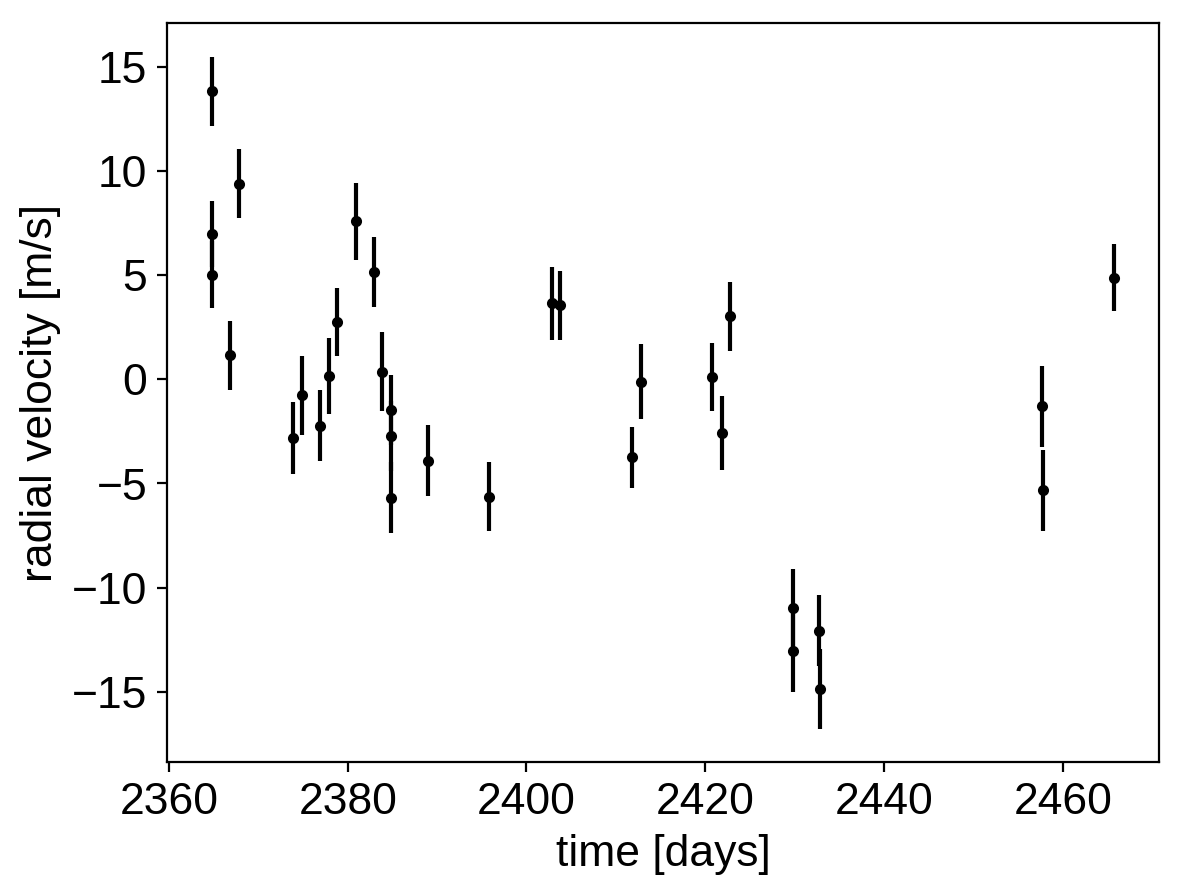

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

Now, we know the periods and transit times for the planets [from the K2 light curve](https://arxiv.org/abs/1511.04497), so let's start by using the :func:`exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [4]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3 (take a look at :ref:`intro-to-pymc3` if you're new to PyMC3).
First, we'll define our priors on the parameters:

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
        
    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    P = pm.Normal("P", mu=np.array(periods), sd=np.array(period_errs), shape=2)

    # Wide log-normal prior for semi-amplitude
    logK = pm.Normal("logK", mu=np.log(Ks), sd=10.0, shape=2)
    
    # This is a sanity check that restricts the semiamplitude to reasonable
    # values because things can get ugly as K -> 0
    pm.Potential("logK_bound", tt.switch(logK < 0, -np.inf, 0.0))
    
    # We also want to keep period physical but this probably won't be hit
    pm.Potential("P_bound", tt.switch(P <= 0, -np.inf, 0.0))

    # Eccentricity & argument of periasteron
    ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, shape=2,
                  testval=np.array([0.1, 0.1]))
    omega = xo.distributions.Angle("omega", shape=2)
    
    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

Now we'll define the orbit model:

In [6]:
with model:
    
    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t0=t0,
        ecc=ecc, omega=omega)
    
    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad = orbit.get_radial_velocity(x, K=tt.exp(logK))
    pm.Deterministic("vrad", vrad)
    
    # Define the background model
    A = np.vander(x - 0.5*(x.min() + x.max()), 3)
    bkg = pm.Deterministic("bkg", tt.dot(A, trend))
    
    # Sum over planets and add the background to get the full model
    rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)

For plotting purposes, it can be useful to also save the model on a fine grid in time.

In [7]:
t = np.linspace(x.min()-5, x.max()+5, 1000)

with model:
    vrad_pred = orbit.get_radial_velocity(t, K=tt.exp(logK))
    pm.Deterministic("vrad_pred", vrad_pred)
    A_pred = np.vander(t - 0.5*(x.min() + x.max()), 3)
    bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
    rv_model_pred = pm.Deterministic("rv_model_pred",
                                     tt.sum(vrad_pred, axis=-1) + bkg_pred)

Now, we can plot the initial model:

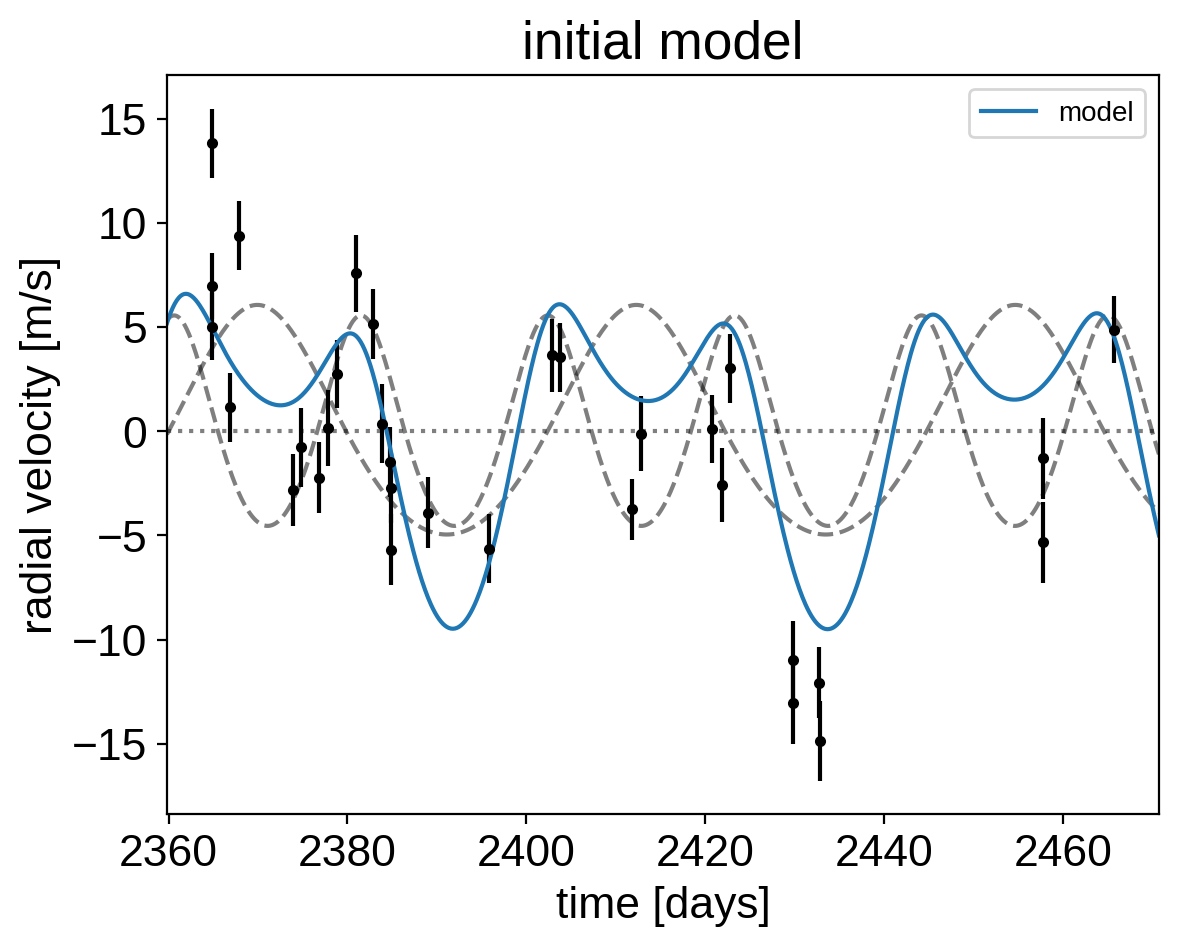

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("initial model");

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's add in the likelihood and fit for the maximum a posterior parameters.

In [9]:
with model:
    
    err = tt.sqrt(yerr**2 + tt.exp(2*logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: -85.64878196427782 -> -70.76432173140468


optimizing logp for variables: ['trend', 'logs', 'omega_angle__', 'ecc_logodds__', 'logK', 'P', 't0']


message: Desired error not necessarily achieved due to precision loss.
logp: -70.76432173140468 -> -21.515004321664016


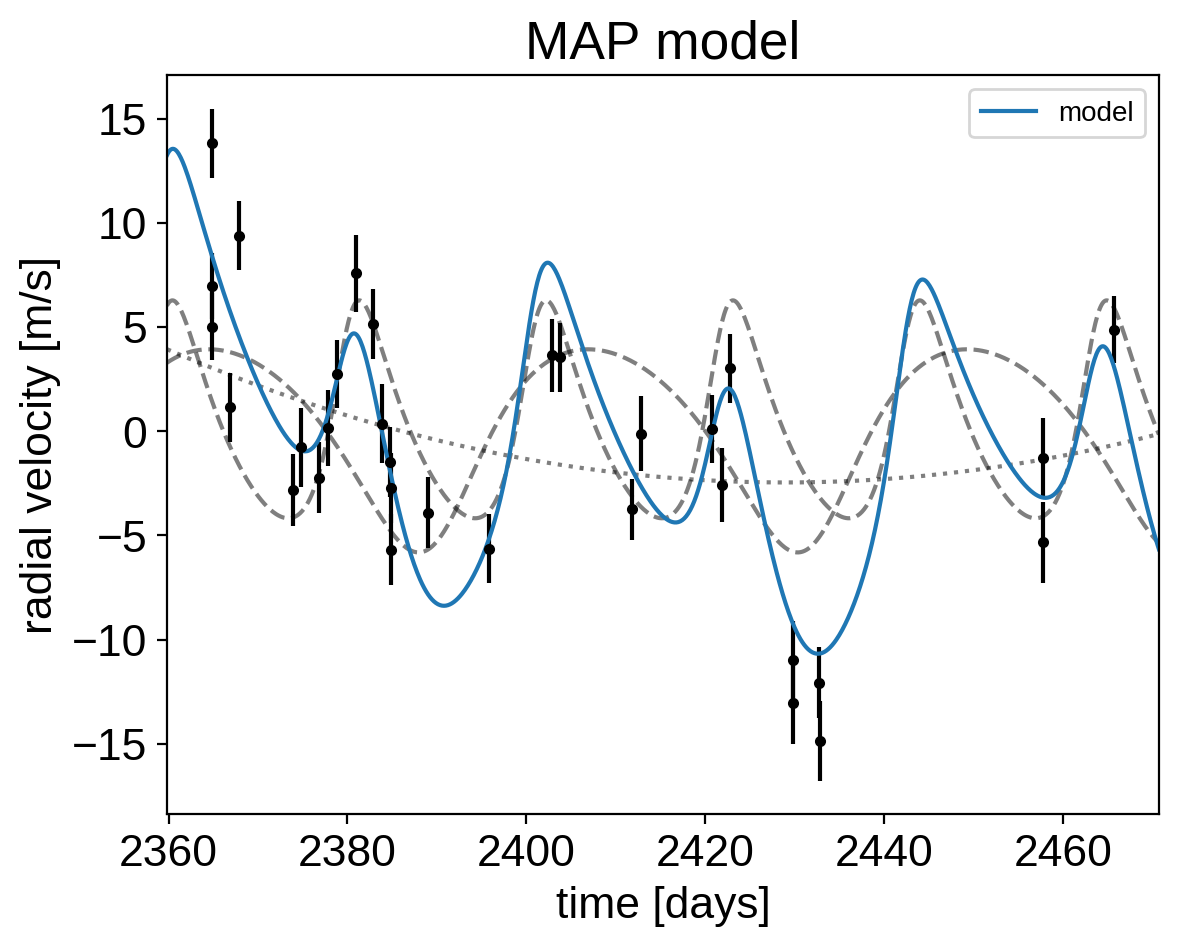

In [10]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("MAP model");

That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use a :class:`exoplanet.PyMC3Sampler` to tune the sampler (see the :ref:`pymc3-extras` tutorial for more information).

In [11]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=4000, start=model.test_point,
                          step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:04, 173.04draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:00<00:05, 133.09draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:00<00:07, 108.91draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:00<00:07, 101.70draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:00<00:08, 90.88draws/s] 

Sampling 4 chains:   8%|▊         | 65/808 [00:00<00:08, 87.40draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:00<00:08, 88.13draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:00<00:08, 87.72draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:00<00:08, 84.00draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:01<00:08, 80.91draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:01<00:08, 80.51draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:01<00:08, 82.79draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:01<00:08, 82.31draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:01<00:08, 81.09draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:01<00:08, 80.78draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:01<00:07, 84.46draws/s]

Sampling 4 chains:  21%|██        | 167/808 [00:01<00:07, 81.91draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:02<00:07, 81.76draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:02<00:07, 83.24draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:02<00:07, 79.86draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:02<00:07, 82.12draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:02<00:07, 83.50draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [00:02<00:06, 84.57draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:02<00:07, 81.39draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:02<00:07, 81.23draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:02<00:06, 82.61draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [00:03<00:06, 81.71draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:03<00:06, 83.38draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:03<00:06, 83.14draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [00:03<00:06, 83.33draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:03<00:06, 80.45draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:03<00:06, 80.90draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:03<00:06, 81.40draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:03<00:05, 83.20draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:03<00:05, 83.17draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [00:03<00:05, 82.75draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:04<00:05, 82.38draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:04<00:05, 81.28draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:04<00:05, 81.46draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:04<00:05, 82.83draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:04<00:05, 84.03draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [00:04<00:05, 81.98draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [00:04<00:04, 82.81draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [00:04<00:04, 81.57draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [00:04<00:04, 80.79draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [00:05<00:04, 81.92draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [00:05<00:04, 82.69draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [00:05<00:04, 83.03draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [00:05<00:04, 82.06draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [00:05<00:04, 80.89draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [00:05<00:04, 80.93draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [00:05<00:03, 81.65draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [00:05<00:03, 82.99draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [00:05<00:03, 83.30draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [00:06<00:03, 82.41draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [00:06<00:03, 83.10draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [00:06<00:03, 81.25draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [00:06<00:03, 80.69draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [00:06<00:03, 82.26draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [00:06<00:03, 82.11draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [00:06<00:02, 82.36draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [00:06<00:02, 81.55draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [00:06<00:02, 81.00draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [00:07<00:02, 81.63draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [00:07<00:02, 81.14draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [00:07<00:02, 83.27draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [00:07<00:02, 83.44draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [00:07<00:02, 83.39draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [00:07<00:02, 80.27draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [00:07<00:02, 80.82draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [00:07<00:01, 80.67draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [00:07<00:01, 82.91draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [00:08<00:01, 82.72draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [00:08<00:01, 83.11draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [00:08<00:01, 81.61draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [00:08<00:01, 80.11draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [00:08<00:01, 82.18draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [00:08<00:01, 82.79draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [00:08<00:00, 84.06draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [00:08<00:00, 81.53draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [00:08<00:00, 82.37draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [00:09<00:00, 81.23draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [00:09<00:00, 83.02draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [00:09<00:00, 82.62draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:09<00:00, 83.41draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [00:09<00:00, 80.14draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [00:09<00:00, 56.50draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:09<00:00, 47.08draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:10<00:00, 77.43draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:02, 165.12draws/s]

Sampling 4 chains:   7%|▋         | 30/408 [00:00<00:02, 127.36draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:00<00:03, 107.62draws/s]

Sampling 4 chains:  12%|█▏        | 47/408 [00:00<00:03, 100.21draws/s]

Sampling 4 chains:  14%|█▍        | 58/408 [00:00<00:03, 101.51draws/s]

Sampling 4 chains:  16%|█▋        | 67/408 [00:00<00:03, 97.76draws/s] 

Sampling 4 chains:  19%|█▉        | 78/408 [00:00<00:03, 100.96draws/s]

Sampling 4 chains:  22%|██▏       | 88/408 [00:00<00:03, 91.96draws/s] 

Sampling 4 chains:  24%|██▍       | 98/408 [00:00<00:03, 94.06draws/s]

Sampling 4 chains:  27%|██▋       | 109/408 [00:01<00:03, 88.48draws/s]

Sampling 4 chains:  30%|██▉       | 121/408 [00:01<00:03, 95.30draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:01<00:03, 88.18draws/s]

Sampling 4 chains:  34%|███▍      | 140/408 [00:01<00:03, 87.62draws/s]

Sampling 4 chains:  37%|███▋      | 151/408 [00:01<00:02, 93.28draws/s]

Sampling 4 chains:  39%|███▉      | 161/408 [00:01<00:02, 88.40draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [00:01<00:02, 89.14draws/s]

Sampling 4 chains:  44%|████▍     | 181/408 [00:01<00:02, 91.20draws/s]

Sampling 4 chains:  47%|████▋     | 192/408 [00:02<00:02, 91.59draws/s]

Sampling 4 chains:  50%|████▉     | 202/408 [00:02<00:02, 90.73draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [00:02<00:02, 90.99draws/s]

Sampling 4 chains:  55%|█████▍    | 224/408 [00:02<00:01, 96.00draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [00:02<00:01, 88.66draws/s]

Sampling 4 chains:  60%|█████▉    | 244/408 [00:02<00:01, 91.66draws/s]

Sampling 4 chains:  62%|██████▎   | 255/408 [00:02<00:01, 92.40draws/s]

Sampling 4 chains:  65%|██████▍   | 265/408 [00:02<00:01, 94.16draws/s]

Sampling 4 chains:  67%|██████▋   | 275/408 [00:02<00:01, 89.41draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [00:03<00:01, 90.73draws/s]

Sampling 4 chains:  73%|███████▎  | 296/408 [00:03<00:01, 89.87draws/s]

Sampling 4 chains:  75%|███████▌  | 306/408 [00:03<00:01, 91.72draws/s]

Sampling 4 chains:  77%|███████▋  | 316/408 [00:03<00:00, 93.31draws/s]

Sampling 4 chains:  80%|███████▉  | 326/408 [00:03<00:00, 94.94draws/s]

Sampling 4 chains:  82%|████████▏ | 336/408 [00:03<00:00, 95.75draws/s]

Sampling 4 chains:  85%|████████▍ | 346/408 [00:03<00:00, 88.62draws/s]

Sampling 4 chains:  87%|████████▋ | 356/408 [00:03<00:00, 91.33draws/s]

Sampling 4 chains:  90%|████████▉ | 367/408 [00:03<00:00, 90.44draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [00:04<00:00, 90.59draws/s]

Sampling 4 chains:  95%|█████████▌| 388/408 [00:04<00:00, 93.50draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [00:04<00:00, 84.36draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:04<00:00, 60.43draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:04<00:00, 85.97draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 26/808 [00:00<00:03, 259.52draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:00<00:03, 206.05draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:00<00:03, 204.48draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:00<00:03, 205.30draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:00<00:03, 205.47draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:00<00:03, 206.19draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:00<00:03, 196.43draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:00<00:03, 208.91draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:00<00:03, 187.62draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:01<00:03, 192.96draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:01<00:02, 194.03draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [00:01<00:02, 207.33draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:01<00:02, 196.71draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:01<00:02, 207.40draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:01<00:02, 215.44draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [00:01<00:01, 232.77draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [00:01<00:01, 243.63draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [00:01<00:01, 204.60draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [00:02<00:01, 202.21draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [00:02<00:01, 204.80draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [00:02<00:01, 202.59draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [00:02<00:01, 222.13draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [00:02<00:01, 224.71draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [00:02<00:01, 210.55draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [00:02<00:01, 210.24draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [00:02<00:01, 196.39draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [00:03<00:01, 179.94draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [00:03<00:00, 182.27draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [00:03<00:00, 194.01draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [00:03<00:00, 213.89draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [00:03<00:00, 212.50draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [00:03<00:00, 201.66draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [00:03<00:00, 170.20draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [00:03<00:00, 138.21draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [00:04<00:00, 80.95draws/s] 

Sampling 4 chains: 100%|█████████▉| 805/808 [00:04<00:00, 57.21draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:04<00:00, 169.09draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 46/1608 [00:00<00:03, 458.53draws/s]

Sampling 4 chains:   6%|▌         | 93/1608 [00:00<00:03, 459.67draws/s]

Sampling 4 chains:   9%|▉         | 148/1608 [00:00<00:03, 481.97draws/s]

Sampling 4 chains:  13%|█▎        | 206/1608 [00:00<00:02, 506.39draws/s]

Sampling 4 chains:  16%|█▌        | 259/1608 [00:00<00:02, 510.96draws/s]

Sampling 4 chains:  20%|█▉        | 316/1608 [00:00<00:02, 526.02draws/s]

Sampling 4 chains:  23%|██▎       | 374/1608 [00:00<00:02, 539.82draws/s]

Sampling 4 chains:  26%|██▋       | 425/1608 [00:00<00:02, 527.95draws/s]

Sampling 4 chains:  30%|██▉       | 478/1608 [00:00<00:02, 527.53draws/s]

Sampling 4 chains:  33%|███▎      | 536/1608 [00:01<00:01, 538.63draws/s]

Sampling 4 chains:  37%|███▋      | 589/1608 [00:01<00:01, 532.81draws/s]

Sampling 4 chains:  40%|████      | 648/1608 [00:01<00:01, 548.66draws/s]

Sampling 4 chains:  44%|████▍     | 707/1608 [00:01<00:01, 558.22draws/s]

Sampling 4 chains:  48%|████▊     | 764/1608 [00:01<00:01, 560.58draws/s]

Sampling 4 chains:  51%|█████     | 822/1608 [00:01<00:01, 565.31draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [00:01<00:01, 552.14draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [00:01<00:01, 558.54draws/s]

Sampling 4 chains:  62%|██████▏   | 996/1608 [00:01<00:01, 566.22draws/s]

Sampling 4 chains:  65%|██████▌   | 1053/1608 [00:01<00:00, 561.92draws/s]

Sampling 4 chains:  69%|██████▉   | 1116/1608 [00:02<00:00, 578.55draws/s]

Sampling 4 chains:  73%|███████▎  | 1175/1608 [00:02<00:00, 575.57draws/s]

Sampling 4 chains:  77%|███████▋  | 1235/1608 [00:02<00:00, 581.70draws/s]

Sampling 4 chains:  80%|████████  | 1294/1608 [00:02<00:00, 570.04draws/s]

Sampling 4 chains:  84%|████████▍ | 1352/1608 [00:02<00:00, 556.44draws/s]

Sampling 4 chains:  88%|████████▊ | 1408/1608 [00:02<00:00, 536.10draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [00:02<00:00, 521.28draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [00:02<00:00, 513.56draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [00:02<00:00, 454.93draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:03<00:00, 503.27draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:00<00:08, 368.39draws/s]

Sampling 4 chains:   3%|▎         | 88/3208 [00:00<00:07, 399.87draws/s]

Sampling 4 chains:   4%|▍         | 131/3208 [00:00<00:07, 408.16draws/s]

Sampling 4 chains:   6%|▌         | 184/3208 [00:00<00:06, 436.21draws/s]

Sampling 4 chains:   8%|▊         | 245/3208 [00:00<00:06, 475.70draws/s]

Sampling 4 chains:   9%|▉         | 299/3208 [00:00<00:05, 492.89draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [00:00<00:05, 503.27draws/s]

Sampling 4 chains:  12%|█▎        | 401/3208 [00:00<00:05, 494.76draws/s]

Sampling 4 chains:  14%|█▍        | 450/3208 [00:00<00:05, 487.41draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [00:01<00:05, 458.32draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [00:01<00:05, 466.58draws/s]

Sampling 4 chains:  19%|█▊        | 596/3208 [00:01<00:05, 472.89draws/s]

Sampling 4 chains:  20%|██        | 646/3208 [00:01<00:05, 480.70draws/s]

Sampling 4 chains:  22%|██▏       | 697/3208 [00:01<00:05, 486.97draws/s]

Sampling 4 chains:  23%|██▎       | 746/3208 [00:01<00:05, 486.05draws/s]

Sampling 4 chains:  25%|██▍       | 799/3208 [00:01<00:04, 494.65draws/s]

Sampling 4 chains:  27%|██▋       | 856/3208 [00:01<00:04, 512.84draws/s]

Sampling 4 chains:  28%|██▊       | 911/3208 [00:01<00:04, 522.71draws/s]

Sampling 4 chains:  30%|███       | 967/3208 [00:01<00:04, 531.14draws/s]

Sampling 4 chains:  32%|███▏      | 1025/3208 [00:02<00:04, 542.73draws/s]

Sampling 4 chains:  34%|███▎      | 1080/3208 [00:02<00:03, 540.90draws/s]

Sampling 4 chains:  35%|███▌      | 1135/3208 [00:02<00:03, 523.60draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [00:02<00:04, 480.81draws/s]

Sampling 4 chains:  39%|███▊      | 1237/3208 [00:02<00:04, 459.12draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [00:02<00:04, 469.29draws/s]

Sampling 4 chains:  42%|████▏     | 1338/3208 [00:02<00:03, 479.92draws/s]

Sampling 4 chains:  43%|████▎     | 1391/3208 [00:02<00:03, 493.37draws/s]

Sampling 4 chains:  45%|████▌     | 1445/3208 [00:02<00:03, 503.71draws/s]

Sampling 4 chains:  47%|████▋     | 1500/3208 [00:03<00:03, 516.51draws/s]

Sampling 4 chains:  49%|████▊     | 1557/3208 [00:03<00:03, 530.59draws/s]

Sampling 4 chains:  50%|█████     | 1611/3208 [00:03<00:03, 528.15draws/s]

Sampling 4 chains:  52%|█████▏    | 1666/3208 [00:03<00:02, 532.30draws/s]

Sampling 4 chains:  54%|█████▎    | 1723/3208 [00:03<00:02, 541.58draws/s]

Sampling 4 chains:  55%|█████▌    | 1778/3208 [00:03<00:02, 526.28draws/s]

Sampling 4 chains:  57%|█████▋    | 1834/3208 [00:03<00:02, 535.50draws/s]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [00:03<00:02, 542.09draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [00:03<00:02, 543.72draws/s]

Sampling 4 chains:  62%|██████▏   | 2001/3208 [00:03<00:02, 545.35draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [00:04<00:02, 544.57draws/s]

Sampling 4 chains:  66%|██████▌   | 2112/3208 [00:04<00:02, 546.40draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [00:04<00:01, 537.03draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [00:04<00:01, 533.19draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [00:04<00:01, 538.82draws/s]

Sampling 4 chains:  73%|███████▎  | 2332/3208 [00:04<00:01, 540.65draws/s]

Sampling 4 chains:  75%|███████▍  | 2391/3208 [00:04<00:01, 554.49draws/s]

Sampling 4 chains:  76%|███████▋  | 2447/3208 [00:04<00:01, 553.35draws/s]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [00:04<00:01, 559.40draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [00:04<00:01, 550.58draws/s]

Sampling 4 chains:  82%|████████▏ | 2618/3208 [00:05<00:01, 544.90draws/s]

Sampling 4 chains:  83%|████████▎ | 2673/3208 [00:05<00:00, 544.55draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [00:05<00:00, 564.99draws/s]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [00:05<00:00, 547.25draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [00:05<00:00, 540.56draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [00:05<00:00, 543.34draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [00:05<00:00, 541.30draws/s]

Sampling 4 chains:  94%|█████████▍| 3013/3208 [00:05<00:00, 467.32draws/s]

Sampling 4 chains:  95%|█████████▌| 3062/3208 [00:05<00:00, 422.77draws/s]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [00:06<00:00, 404.18draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [00:06<00:00, 406.16draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [00:06<00:00, 342.57draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:06<00:00, 494.75draws/s]

Sampling 4 chains:   0%|          | 0/9208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 34/9208 [00:00<00:27, 338.70draws/s]

Sampling 4 chains:   1%|          | 85/9208 [00:00<00:24, 375.40draws/s]

Sampling 4 chains:   2%|▏         | 139/9208 [00:00<00:21, 412.98draws/s]

Sampling 4 chains:   2%|▏         | 203/9208 [00:00<00:19, 462.07draws/s]

Sampling 4 chains:   3%|▎         | 256/9208 [00:00<00:18, 478.83draws/s]

Sampling 4 chains:   3%|▎         | 321/9208 [00:00<00:17, 517.73draws/s]

Sampling 4 chains:   4%|▍         | 375/9208 [00:00<00:16, 521.00draws/s]

Sampling 4 chains:   5%|▍         | 433/9208 [00:00<00:16, 534.92draws/s]

Sampling 4 chains:   5%|▌         | 487/9208 [00:00<00:16, 536.35draws/s]

Sampling 4 chains:   6%|▌         | 548/9208 [00:01<00:15, 552.77draws/s]

Sampling 4 chains:   7%|▋         | 605/9208 [00:01<00:15, 555.90draws/s]

Sampling 4 chains:   7%|▋         | 663/9208 [00:01<00:15, 560.90draws/s]

Sampling 4 chains:   8%|▊         | 720/9208 [00:01<00:15, 555.85draws/s]

Sampling 4 chains:   8%|▊         | 778/9208 [00:01<00:14, 562.15draws/s]

Sampling 4 chains:   9%|▉         | 835/9208 [00:01<00:15, 533.21draws/s]

Sampling 4 chains:  10%|▉         | 893/9208 [00:01<00:15, 545.49draws/s]

Sampling 4 chains:  10%|█         | 951/9208 [00:01<00:14, 552.74draws/s]

Sampling 4 chains:  11%|█         | 1016/9208 [00:01<00:14, 577.97draws/s]

Sampling 4 chains:  12%|█▏        | 1075/9208 [00:01<00:14, 570.35draws/s]

Sampling 4 chains:  12%|█▏        | 1133/9208 [00:02<00:14, 569.73draws/s]

Sampling 4 chains:  13%|█▎        | 1191/9208 [00:02<00:14, 567.81draws/s]

Sampling 4 chains:  14%|█▎        | 1248/9208 [00:02<00:14, 561.58draws/s]

Sampling 4 chains:  14%|█▍        | 1313/9208 [00:02<00:13, 583.91draws/s]

Sampling 4 chains:  15%|█▍        | 1372/9208 [00:02<00:13, 580.71draws/s]

Sampling 4 chains:  16%|█▌        | 1431/9208 [00:02<00:14, 539.52draws/s]

Sampling 4 chains:  16%|█▌        | 1489/9208 [00:02<00:14, 548.29draws/s]

Sampling 4 chains:  17%|█▋        | 1545/9208 [00:02<00:14, 544.24draws/s]

Sampling 4 chains:  17%|█▋        | 1600/9208 [00:02<00:14, 540.56draws/s]

Sampling 4 chains:  18%|█▊        | 1658/9208 [00:03<00:13, 548.86draws/s]

Sampling 4 chains:  19%|█▊        | 1717/9208 [00:03<00:13, 559.81draws/s]

Sampling 4 chains:  19%|█▉        | 1775/9208 [00:03<00:13, 565.59draws/s]

Sampling 4 chains:  20%|█▉        | 1832/9208 [00:03<00:13, 561.63draws/s]

Sampling 4 chains:  21%|██        | 1892/9208 [00:03<00:12, 571.71draws/s]

Sampling 4 chains:  21%|██        | 1950/9208 [00:03<00:13, 552.26draws/s]

Sampling 4 chains:  22%|██▏       | 2006/9208 [00:03<00:13, 522.79draws/s]

Sampling 4 chains:  22%|██▏       | 2060/9208 [00:03<00:13, 527.79draws/s]

Sampling 4 chains:  23%|██▎       | 2119/9208 [00:03<00:13, 544.97draws/s]

Sampling 4 chains:  24%|██▎       | 2178/9208 [00:03<00:12, 557.55draws/s]

Sampling 4 chains:  24%|██▍       | 2239/9208 [00:04<00:12, 571.32draws/s]

Sampling 4 chains:  25%|██▍       | 2298/9208 [00:04<00:11, 576.69draws/s]

Sampling 4 chains:  26%|██▌       | 2364/9208 [00:04<00:11, 596.62draws/s]

Sampling 4 chains:  26%|██▋       | 2425/9208 [00:04<00:11, 597.29draws/s]

Sampling 4 chains:  27%|██▋       | 2486/9208 [00:04<00:11, 599.88draws/s]

Sampling 4 chains:  28%|██▊       | 2547/9208 [00:04<00:11, 598.56draws/s]

Sampling 4 chains:  28%|██▊       | 2609/9208 [00:04<00:10, 601.36draws/s]

Sampling 4 chains:  29%|██▉       | 2670/9208 [00:04<00:11, 581.84draws/s]

Sampling 4 chains:  30%|██▉       | 2729/9208 [00:04<00:11, 580.32draws/s]

Sampling 4 chains:  30%|███       | 2789/9208 [00:04<00:10, 585.42draws/s]

Sampling 4 chains:  31%|███       | 2848/9208 [00:05<00:10, 579.00draws/s]

Sampling 4 chains:  32%|███▏      | 2909/9208 [00:05<00:10, 584.95draws/s]

Sampling 4 chains:  32%|███▏      | 2968/9208 [00:05<00:10, 579.59draws/s]

Sampling 4 chains:  33%|███▎      | 3027/9208 [00:05<00:10, 579.46draws/s]

Sampling 4 chains:  34%|███▎      | 3086/9208 [00:05<00:10, 580.89draws/s]

Sampling 4 chains:  34%|███▍      | 3145/9208 [00:05<00:10, 579.18draws/s]

Sampling 4 chains:  35%|███▍      | 3210/9208 [00:05<00:10, 595.01draws/s]

Sampling 4 chains:  36%|███▌      | 3270/9208 [00:05<00:10, 581.12draws/s]

Sampling 4 chains:  36%|███▌      | 3329/9208 [00:05<00:10, 581.35draws/s]

Sampling 4 chains:  37%|███▋      | 3391/9208 [00:05<00:09, 592.15draws/s]

Sampling 4 chains:  37%|███▋      | 3451/9208 [00:06<00:09, 578.01draws/s]

Sampling 4 chains:  38%|███▊      | 3510/9208 [00:06<00:09, 578.61draws/s]

Sampling 4 chains:  39%|███▊      | 3568/9208 [00:06<00:09, 571.20draws/s]

Sampling 4 chains:  39%|███▉      | 3626/9208 [00:06<00:09, 567.72draws/s]

Sampling 4 chains:  40%|████      | 3684/9208 [00:06<00:09, 568.40draws/s]

Sampling 4 chains:  41%|████      | 3743/9208 [00:06<00:09, 573.29draws/s]

Sampling 4 chains:  41%|████▏     | 3801/9208 [00:06<00:09, 565.14draws/s]

Sampling 4 chains:  42%|████▏     | 3858/9208 [00:06<00:09, 565.60draws/s]

Sampling 4 chains:  43%|████▎     | 3918/9208 [00:06<00:09, 573.42draws/s]

Sampling 4 chains:  43%|████▎     | 3976/9208 [00:07<00:09, 573.25draws/s]

Sampling 4 chains:  44%|████▍     | 4034/9208 [00:07<00:09, 556.28draws/s]

Sampling 4 chains:  44%|████▍     | 4090/9208 [00:07<00:09, 551.27draws/s]

Sampling 4 chains:  45%|████▌     | 4147/9208 [00:07<00:09, 556.65draws/s]

Sampling 4 chains:  46%|████▌     | 4204/9208 [00:07<00:08, 560.54draws/s]

Sampling 4 chains:  46%|████▋     | 4267/9208 [00:07<00:08, 577.49draws/s]

Sampling 4 chains:  47%|████▋     | 4325/9208 [00:07<00:08, 568.95draws/s]

Sampling 4 chains:  48%|████▊     | 4386/9208 [00:07<00:08, 578.90draws/s]

Sampling 4 chains:  48%|████▊     | 4445/9208 [00:07<00:08, 566.55draws/s]

Sampling 4 chains:  49%|████▉     | 4502/9208 [00:07<00:08, 564.00draws/s]

Sampling 4 chains:  50%|████▉     | 4560/9208 [00:08<00:08, 568.65draws/s]

Sampling 4 chains:  50%|█████     | 4618/9208 [00:08<00:08, 571.73draws/s]

Sampling 4 chains:  51%|█████     | 4676/9208 [00:08<00:08, 563.25draws/s]

Sampling 4 chains:  51%|█████▏    | 4733/9208 [00:08<00:07, 560.22draws/s]

Sampling 4 chains:  52%|█████▏    | 4790/9208 [00:08<00:08, 537.30draws/s]

Sampling 4 chains:  53%|█████▎    | 4848/9208 [00:08<00:07, 548.66draws/s]

Sampling 4 chains:  53%|█████▎    | 4908/9208 [00:08<00:07, 562.16draws/s]

Sampling 4 chains:  54%|█████▍    | 4965/9208 [00:08<00:07, 556.18draws/s]

Sampling 4 chains:  55%|█████▍    | 5023/9208 [00:08<00:07, 561.41draws/s]

Sampling 4 chains:  55%|█████▌    | 5081/9208 [00:08<00:07, 563.90draws/s]

Sampling 4 chains:  56%|█████▌    | 5138/9208 [00:09<00:07, 515.92draws/s]

Sampling 4 chains:  56%|█████▋    | 5191/9208 [00:09<00:07, 503.88draws/s]

Sampling 4 chains:  57%|█████▋    | 5243/9208 [00:09<00:07, 507.70draws/s]

Sampling 4 chains:  58%|█████▊    | 5295/9208 [00:09<00:07, 508.61draws/s]

Sampling 4 chains:  58%|█████▊    | 5352/9208 [00:09<00:07, 525.58draws/s]

Sampling 4 chains:  59%|█████▉    | 5413/9208 [00:09<00:06, 546.85draws/s]

Sampling 4 chains:  59%|█████▉    | 5469/9208 [00:09<00:06, 550.66draws/s]

Sampling 4 chains:  60%|██████    | 5530/9208 [00:09<00:06, 564.70draws/s]

Sampling 4 chains:  61%|██████    | 5588/9208 [00:09<00:06, 568.10draws/s]

Sampling 4 chains:  61%|██████▏   | 5646/9208 [00:10<00:06, 571.04draws/s]

Sampling 4 chains:  62%|██████▏   | 5706/9208 [00:10<00:06, 577.89draws/s]

Sampling 4 chains:  63%|██████▎   | 5768/9208 [00:10<00:05, 588.78draws/s]

Sampling 4 chains:  63%|██████▎   | 5830/9208 [00:10<00:05, 593.07draws/s]

Sampling 4 chains:  64%|██████▍   | 5890/9208 [00:10<00:05, 591.95draws/s]

Sampling 4 chains:  65%|██████▍   | 5950/9208 [00:10<00:05, 588.95draws/s]

Sampling 4 chains:  65%|██████▌   | 6009/9208 [00:10<00:05, 584.45draws/s]

Sampling 4 chains:  66%|██████▌   | 6071/9208 [00:10<00:05, 592.64draws/s]

Sampling 4 chains:  67%|██████▋   | 6131/9208 [00:10<00:05, 578.02draws/s]

Sampling 4 chains:  67%|██████▋   | 6192/9208 [00:10<00:05, 584.84draws/s]

Sampling 4 chains:  68%|██████▊   | 6251/9208 [00:11<00:05, 578.50draws/s]

Sampling 4 chains:  69%|██████▊   | 6310/9208 [00:11<00:04, 581.69draws/s]

Sampling 4 chains:  69%|██████▉   | 6369/9208 [00:11<00:04, 577.97draws/s]

Sampling 4 chains:  70%|██████▉   | 6427/9208 [00:11<00:04, 571.37draws/s]

Sampling 4 chains:  70%|███████   | 6486/9208 [00:11<00:04, 574.69draws/s]

Sampling 4 chains:  71%|███████   | 6544/9208 [00:11<00:04, 574.49draws/s]

Sampling 4 chains:  72%|███████▏  | 6605/9208 [00:11<00:04, 579.56draws/s]

Sampling 4 chains:  72%|███████▏  | 6663/9208 [00:11<00:04, 578.04draws/s]

Sampling 4 chains:  73%|███████▎  | 6721/9208 [00:11<00:04, 574.69draws/s]

Sampling 4 chains:  74%|███████▎  | 6779/9208 [00:11<00:04, 567.80draws/s]

Sampling 4 chains:  74%|███████▍  | 6840/9208 [00:12<00:04, 579.24draws/s]

Sampling 4 chains:  75%|███████▍  | 6903/9208 [00:12<00:03, 593.26draws/s]

Sampling 4 chains:  76%|███████▌  | 6966/9208 [00:12<00:03, 601.10draws/s]

Sampling 4 chains:  76%|███████▋  | 7031/9208 [00:12<00:03, 613.18draws/s]

Sampling 4 chains:  77%|███████▋  | 7093/9208 [00:12<00:03, 602.17draws/s]

Sampling 4 chains:  78%|███████▊  | 7154/9208 [00:12<00:03, 603.17draws/s]

Sampling 4 chains:  78%|███████▊  | 7215/9208 [00:12<00:03, 588.44draws/s]

Sampling 4 chains:  79%|███████▉  | 7281/9208 [00:12<00:03, 604.40draws/s]

Sampling 4 chains:  80%|███████▉  | 7342/9208 [00:12<00:03, 598.07draws/s]

Sampling 4 chains:  80%|████████  | 7402/9208 [00:13<00:03, 587.75draws/s]

Sampling 4 chains:  81%|████████  | 7461/9208 [00:13<00:03, 579.27draws/s]

Sampling 4 chains:  82%|████████▏ | 7521/9208 [00:13<00:02, 584.11draws/s]

Sampling 4 chains:  82%|████████▏ | 7580/9208 [00:13<00:02, 574.47draws/s]

Sampling 4 chains:  83%|████████▎ | 7639/9208 [00:13<00:02, 577.90draws/s]

Sampling 4 chains:  84%|████████▎ | 7699/9208 [00:13<00:02, 582.34draws/s]

Sampling 4 chains:  84%|████████▍ | 7760/9208 [00:13<00:02, 586.23draws/s]

Sampling 4 chains:  85%|████████▍ | 7819/9208 [00:13<00:02, 569.42draws/s]

Sampling 4 chains:  86%|████████▌ | 7877/9208 [00:13<00:02, 556.72draws/s]

Sampling 4 chains:  86%|████████▌ | 7939/9208 [00:13<00:02, 574.07draws/s]

Sampling 4 chains:  87%|████████▋ | 7999/9208 [00:14<00:02, 578.96draws/s]

Sampling 4 chains:  88%|████████▊ | 8058/9208 [00:14<00:01, 578.97draws/s]

Sampling 4 chains:  88%|████████▊ | 8117/9208 [00:14<00:01, 582.12draws/s]

Sampling 4 chains:  89%|████████▉ | 8176/9208 [00:14<00:01, 581.99draws/s]

Sampling 4 chains:  89%|████████▉ | 8235/9208 [00:14<00:01, 575.04draws/s]

Sampling 4 chains:  90%|█████████ | 8301/9208 [00:14<00:01, 597.21draws/s]

Sampling 4 chains:  91%|█████████ | 8361/9208 [00:14<00:01, 597.21draws/s]

Sampling 4 chains:  91%|█████████▏| 8423/9208 [00:14<00:01, 601.03draws/s]

Sampling 4 chains:  92%|█████████▏| 8484/9208 [00:14<00:01, 600.37draws/s]

Sampling 4 chains:  93%|█████████▎| 8545/9208 [00:14<00:01, 597.01draws/s]

Sampling 4 chains:  93%|█████████▎| 8606/9208 [00:15<00:01, 600.54draws/s]

Sampling 4 chains:  94%|█████████▍| 8667/9208 [00:15<00:01, 516.64draws/s]

Sampling 4 chains:  95%|█████████▍| 8721/9208 [00:15<00:01, 474.00draws/s]

Sampling 4 chains:  95%|█████████▌| 8771/9208 [00:15<00:01, 392.64draws/s]

Sampling 4 chains:  96%|█████████▌| 8815/9208 [00:15<00:01, 358.57draws/s]

Sampling 4 chains:  96%|█████████▌| 8855/9208 [00:15<00:01, 345.51draws/s]

Sampling 4 chains:  97%|█████████▋| 8892/9208 [00:16<00:01, 279.24draws/s]

Sampling 4 chains:  97%|█████████▋| 8924/9208 [00:16<00:01, 226.41draws/s]

Sampling 4 chains:  97%|█████████▋| 8951/9208 [00:16<00:01, 203.26draws/s]

Sampling 4 chains:  97%|█████████▋| 8975/9208 [00:16<00:01, 186.97draws/s]

Sampling 4 chains:  98%|█████████▊| 8997/9208 [00:16<00:01, 174.42draws/s]

Sampling 4 chains:  98%|█████████▊| 9017/9208 [00:16<00:01, 164.04draws/s]

Sampling 4 chains:  98%|█████████▊| 9035/9208 [00:16<00:01, 162.99draws/s]

Sampling 4 chains:  98%|█████████▊| 9053/9208 [00:17<00:00, 166.72draws/s]

Sampling 4 chains:  99%|█████████▊| 9071/9208 [00:17<00:00, 161.95draws/s]

Sampling 4 chains:  99%|█████████▊| 9088/9208 [00:17<00:00, 157.58draws/s]

Sampling 4 chains:  99%|█████████▉| 9105/9208 [00:17<00:00, 158.90draws/s]

Sampling 4 chains:  99%|█████████▉| 9122/9208 [00:17<00:00, 156.96draws/s]

Sampling 4 chains:  99%|█████████▉| 9138/9208 [00:17<00:00, 155.76draws/s]

Sampling 4 chains:  99%|█████████▉| 9154/9208 [00:17<00:00, 156.46draws/s]

Sampling 4 chains: 100%|█████████▉| 9170/9208 [00:17<00:00, 152.63draws/s]

Sampling 4 chains: 100%|█████████▉| 9186/9208 [00:17<00:00, 148.30draws/s]

Sampling 4 chains: 100%|█████████▉| 9201/9208 [00:18<00:00, 148.46draws/s]

Sampling 4 chains: 100%|██████████| 9208/9208 [00:18<00:00, 509.18draws/s]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 38/1208 [00:00<00:03, 379.84draws/s]

Sampling 4 chains:   8%|▊         | 93/1208 [00:00<00:02, 417.68draws/s]

Sampling 4 chains:  12%|█▏        | 144/1208 [00:00<00:02, 436.42draws/s]

Sampling 4 chains:  16%|█▌        | 192/1208 [00:00<00:02, 446.08draws/s]

Sampling 4 chains:  20%|██        | 246/1208 [00:00<00:02, 468.68draws/s]

Sampling 4 chains:  25%|██▍       | 300/1208 [00:00<00:01, 485.39draws/s]

Sampling 4 chains:  30%|██▉       | 357/1208 [00:00<00:01, 507.30draws/s]

Sampling 4 chains:  34%|███▍      | 415/1208 [00:00<00:01, 526.13draws/s]

Sampling 4 chains:  39%|███▉      | 475/1208 [00:00<00:01, 542.23draws/s]

Sampling 4 chains:  44%|████▍     | 529/1208 [00:01<00:01, 514.54draws/s]

Sampling 4 chains:  48%|████▊     | 581/1208 [00:01<00:01, 511.19draws/s]

Sampling 4 chains:  52%|█████▏    | 632/1208 [00:01<00:01, 500.44draws/s]

Sampling 4 chains:  56%|█████▋    | 682/1208 [00:01<00:01, 499.20draws/s]

Sampling 4 chains:  61%|██████    | 732/1208 [00:01<00:01, 465.97draws/s]

Sampling 4 chains:  65%|██████▍   | 782/1208 [00:01<00:00, 474.71draws/s]

Sampling 4 chains:  70%|██████▉   | 844/1208 [00:01<00:00, 508.66draws/s]

Sampling 4 chains:  74%|███████▍  | 899/1208 [00:01<00:00, 517.97draws/s]

Sampling 4 chains:  79%|███████▉  | 958/1208 [00:01<00:00, 536.01draws/s]

Sampling 4 chains:  84%|████████▍ | 1013/1208 [00:01<00:00, 534.68draws/s]

Sampling 4 chains:  88%|████████▊ | 1067/1208 [00:02<00:00, 515.70draws/s]

Sampling 4 chains:  93%|█████████▎| 1120/1208 [00:02<00:00, 451.37draws/s]

Sampling 4 chains:  97%|█████████▋| 1167/1208 [00:02<00:00, 310.03draws/s]

Sampling 4 chains: 100%|█████████▉| 1206/1208 [00:02<00:00, 228.95draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [00:02<00:00, 429.77draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 39/16000 [00:00<00:41, 386.43draws/s]

Sampling 4 chains:   1%|          | 90/16000 [00:00<00:38, 416.33draws/s]

Sampling 4 chains:   1%|          | 142/16000 [00:00<00:35, 440.56draws/s]

Sampling 4 chains:   1%|▏         | 200/16000 [00:00<00:33, 472.59draws/s]

Sampling 4 chains:   2%|▏         | 258/16000 [00:00<00:31, 498.84draws/s]

Sampling 4 chains:   2%|▏         | 315/16000 [00:00<00:30, 516.91draws/s]

Sampling 4 chains:   2%|▏         | 374/16000 [00:00<00:29, 536.13draws/s]

Sampling 4 chains:   3%|▎         | 433/16000 [00:00<00:28, 549.41draws/s]

Sampling 4 chains:   3%|▎         | 490/16000 [00:00<00:28, 553.14draws/s]

Sampling 4 chains:   3%|▎         | 545/16000 [00:01<00:29, 529.39draws/s]

Sampling 4 chains:   4%|▎         | 598/16000 [00:01<00:29, 527.55draws/s]

Sampling 4 chains:   4%|▍         | 658/16000 [00:01<00:28, 546.84draws/s]

Sampling 4 chains:   4%|▍         | 715/16000 [00:01<00:27, 551.53draws/s]

Sampling 4 chains:   5%|▍         | 773/16000 [00:01<00:27, 559.77draws/s]

Sampling 4 chains:   5%|▌         | 833/16000 [00:01<00:26, 567.74draws/s]

Sampling 4 chains:   6%|▌         | 890/16000 [00:01<00:27, 555.62draws/s]

Sampling 4 chains:   6%|▌         | 946/16000 [00:01<00:27, 556.62draws/s]

Sampling 4 chains:   6%|▋         | 1002/16000 [00:01<00:27, 555.24draws/s]

Sampling 4 chains:   7%|▋         | 1058/16000 [00:01<00:26, 554.74draws/s]

Sampling 4 chains:   7%|▋         | 1117/16000 [00:02<00:26, 563.38draws/s]

Sampling 4 chains:   7%|▋         | 1174/16000 [00:02<00:26, 555.63draws/s]

Sampling 4 chains:   8%|▊         | 1233/16000 [00:02<00:26, 564.15draws/s]

Sampling 4 chains:   8%|▊         | 1290/16000 [00:02<00:26, 557.68draws/s]

Sampling 4 chains:   8%|▊         | 1348/16000 [00:02<00:26, 562.43draws/s]

Sampling 4 chains:   9%|▉         | 1405/16000 [00:02<00:26, 553.21draws/s]

Sampling 4 chains:   9%|▉         | 1461/16000 [00:02<00:27, 537.27draws/s]

Sampling 4 chains:   9%|▉         | 1517/16000 [00:02<00:26, 542.80draws/s]

Sampling 4 chains:  10%|▉         | 1575/16000 [00:02<00:26, 550.14draws/s]

Sampling 4 chains:  10%|█         | 1631/16000 [00:02<00:25, 553.03draws/s]

Sampling 4 chains:  11%|█         | 1689/16000 [00:03<00:25, 560.48draws/s]

Sampling 4 chains:  11%|█         | 1746/16000 [00:03<00:25, 553.08draws/s]

Sampling 4 chains:  11%|█▏        | 1802/16000 [00:03<00:26, 534.21draws/s]

Sampling 4 chains:  12%|█▏        | 1859/16000 [00:03<00:25, 544.37draws/s]

Sampling 4 chains:  12%|█▏        | 1914/16000 [00:03<00:25, 542.63draws/s]

Sampling 4 chains:  12%|█▏        | 1972/16000 [00:03<00:25, 552.02draws/s]

Sampling 4 chains:  13%|█▎        | 2028/16000 [00:03<00:25, 541.56draws/s]

Sampling 4 chains:  13%|█▎        | 2084/16000 [00:03<00:25, 544.62draws/s]

Sampling 4 chains:  13%|█▎        | 2139/16000 [00:03<00:25, 542.62draws/s]

Sampling 4 chains:  14%|█▎        | 2199/16000 [00:04<00:24, 557.71draws/s]

Sampling 4 chains:  14%|█▍        | 2255/16000 [00:04<00:24, 555.58draws/s]

Sampling 4 chains:  14%|█▍        | 2311/16000 [00:04<00:24, 550.12draws/s]

Sampling 4 chains:  15%|█▍        | 2367/16000 [00:04<00:24, 545.39draws/s]

Sampling 4 chains:  15%|█▌        | 2425/16000 [00:04<00:24, 553.84draws/s]

Sampling 4 chains:  16%|█▌        | 2483/16000 [00:04<00:24, 558.46draws/s]

Sampling 4 chains:  16%|█▌        | 2540/16000 [00:04<00:23, 561.43draws/s]

Sampling 4 chains:  16%|█▌        | 2597/16000 [00:04<00:23, 562.37draws/s]

Sampling 4 chains:  17%|█▋        | 2656/16000 [00:04<00:23, 570.12draws/s]

Sampling 4 chains:  17%|█▋        | 2714/16000 [00:04<00:23, 563.35draws/s]

Sampling 4 chains:  17%|█▋        | 2771/16000 [00:05<00:24, 548.68draws/s]

Sampling 4 chains:  18%|█▊        | 2828/16000 [00:05<00:23, 553.93draws/s]

Sampling 4 chains:  18%|█▊        | 2884/16000 [00:05<00:23, 551.13draws/s]

Sampling 4 chains:  18%|█▊        | 2940/16000 [00:05<00:23, 552.57draws/s]

Sampling 4 chains:  19%|█▊        | 2996/16000 [00:05<00:23, 545.85draws/s]

Sampling 4 chains:  19%|█▉        | 3051/16000 [00:05<00:23, 542.92draws/s]

Sampling 4 chains:  19%|█▉        | 3106/16000 [00:05<00:23, 544.52draws/s]

Sampling 4 chains:  20%|█▉        | 3162/16000 [00:05<00:23, 547.65draws/s]

Sampling 4 chains:  20%|██        | 3219/16000 [00:05<00:23, 550.09draws/s]

Sampling 4 chains:  20%|██        | 3275/16000 [00:05<00:23, 546.92draws/s]

Sampling 4 chains:  21%|██        | 3330/16000 [00:06<00:23, 540.98draws/s]

Sampling 4 chains:  21%|██        | 3385/16000 [00:06<00:23, 538.02draws/s]

Sampling 4 chains:  21%|██▏       | 3439/16000 [00:06<00:23, 529.87draws/s]

Sampling 4 chains:  22%|██▏       | 3493/16000 [00:06<00:23, 528.55draws/s]

Sampling 4 chains:  22%|██▏       | 3546/16000 [00:06<00:24, 514.12draws/s]

Sampling 4 chains:  22%|██▏       | 3598/16000 [00:06<00:24, 514.61draws/s]

Sampling 4 chains:  23%|██▎       | 3653/16000 [00:06<00:23, 523.31draws/s]

Sampling 4 chains:  23%|██▎       | 3709/16000 [00:06<00:23, 533.30draws/s]

Sampling 4 chains:  24%|██▎       | 3763/16000 [00:06<00:22, 533.05draws/s]

Sampling 4 chains:  24%|██▍       | 3819/16000 [00:06<00:22, 538.71draws/s]

Sampling 4 chains:  24%|██▍       | 3873/16000 [00:07<00:22, 533.66draws/s]

Sampling 4 chains:  25%|██▍       | 3928/16000 [00:07<00:22, 537.74draws/s]

Sampling 4 chains:  25%|██▍       | 3983/16000 [00:07<00:22, 540.96draws/s]

Sampling 4 chains:  25%|██▌       | 4039/16000 [00:07<00:21, 546.52draws/s]

Sampling 4 chains:  26%|██▌       | 4094/16000 [00:07<00:21, 542.89draws/s]

Sampling 4 chains:  26%|██▌       | 4149/16000 [00:07<00:21, 542.07draws/s]

Sampling 4 chains:  26%|██▋       | 4205/16000 [00:07<00:21, 546.48draws/s]

Sampling 4 chains:  27%|██▋       | 4262/16000 [00:07<00:21, 551.18draws/s]

Sampling 4 chains:  27%|██▋       | 4319/16000 [00:07<00:21, 555.20draws/s]

Sampling 4 chains:  27%|██▋       | 4375/16000 [00:08<00:21, 544.78draws/s]

Sampling 4 chains:  28%|██▊       | 4432/16000 [00:08<00:20, 551.02draws/s]

Sampling 4 chains:  28%|██▊       | 4490/16000 [00:08<00:20, 557.96draws/s]

Sampling 4 chains:  28%|██▊       | 4546/16000 [00:08<00:21, 528.56draws/s]

Sampling 4 chains:  29%|██▉       | 4600/16000 [00:08<00:21, 523.60draws/s]

Sampling 4 chains:  29%|██▉       | 4653/16000 [00:08<00:21, 519.57draws/s]

Sampling 4 chains:  29%|██▉       | 4710/16000 [00:08<00:21, 533.57draws/s]

Sampling 4 chains:  30%|██▉       | 4764/16000 [00:08<00:21, 524.13draws/s]

Sampling 4 chains:  30%|███       | 4820/16000 [00:08<00:20, 533.15draws/s]

Sampling 4 chains:  30%|███       | 4876/16000 [00:08<00:20, 540.30draws/s]

Sampling 4 chains:  31%|███       | 4931/16000 [00:09<00:20, 540.29draws/s]

Sampling 4 chains:  31%|███       | 4986/16000 [00:09<00:20, 537.30draws/s]

Sampling 4 chains:  32%|███▏      | 5044/16000 [00:09<00:20, 546.87draws/s]

Sampling 4 chains:  32%|███▏      | 5101/16000 [00:09<00:19, 552.43draws/s]

Sampling 4 chains:  32%|███▏      | 5157/16000 [00:09<00:19, 545.41draws/s]

Sampling 4 chains:  33%|███▎      | 5212/16000 [00:09<00:20, 533.65draws/s]

Sampling 4 chains:  33%|███▎      | 5266/16000 [00:09<00:20, 530.56draws/s]

Sampling 4 chains:  33%|███▎      | 5321/16000 [00:09<00:19, 534.84draws/s]

Sampling 4 chains:  34%|███▎      | 5375/16000 [00:09<00:20, 528.83draws/s]

Sampling 4 chains:  34%|███▍      | 5428/16000 [00:09<00:20, 524.37draws/s]

Sampling 4 chains:  34%|███▍      | 5481/16000 [00:10<00:20, 516.23draws/s]

Sampling 4 chains:  35%|███▍      | 5537/16000 [00:10<00:19, 527.29draws/s]

Sampling 4 chains:  35%|███▍      | 5594/16000 [00:10<00:19, 538.07draws/s]

Sampling 4 chains:  35%|███▌      | 5649/16000 [00:10<00:19, 541.36draws/s]

Sampling 4 chains:  36%|███▌      | 5706/16000 [00:10<00:18, 548.68draws/s]

Sampling 4 chains:  36%|███▌      | 5761/16000 [00:10<00:19, 533.32draws/s]

Sampling 4 chains:  36%|███▋      | 5818/16000 [00:10<00:18, 540.17draws/s]

Sampling 4 chains:  37%|███▋      | 5875/16000 [00:10<00:18, 547.01draws/s]

Sampling 4 chains:  37%|███▋      | 5930/16000 [00:10<00:18, 545.13draws/s]

Sampling 4 chains:  37%|███▋      | 5988/16000 [00:11<00:18, 553.64draws/s]

Sampling 4 chains:  38%|███▊      | 6044/16000 [00:11<00:18, 552.01draws/s]

Sampling 4 chains:  38%|███▊      | 6101/16000 [00:11<00:17, 554.45draws/s]

Sampling 4 chains:  38%|███▊      | 6159/16000 [00:11<00:17, 556.46draws/s]

Sampling 4 chains:  39%|███▉      | 6216/16000 [00:11<00:17, 559.39draws/s]

Sampling 4 chains:  39%|███▉      | 6272/16000 [00:11<00:17, 558.33draws/s]

Sampling 4 chains:  40%|███▉      | 6330/16000 [00:11<00:17, 563.12draws/s]

Sampling 4 chains:  40%|███▉      | 6387/16000 [00:11<00:17, 557.19draws/s]

Sampling 4 chains:  40%|████      | 6444/16000 [00:11<00:17, 559.29draws/s]

Sampling 4 chains:  41%|████      | 6500/16000 [00:11<00:17, 553.76draws/s]

Sampling 4 chains:  41%|████      | 6556/16000 [00:12<00:17, 549.71draws/s]

Sampling 4 chains:  41%|████▏     | 6614/16000 [00:12<00:16, 553.93draws/s]

Sampling 4 chains:  42%|████▏     | 6672/16000 [00:12<00:16, 561.14draws/s]

Sampling 4 chains:  42%|████▏     | 6730/16000 [00:12<00:16, 566.34draws/s]

Sampling 4 chains:  42%|████▏     | 6789/16000 [00:12<00:16, 567.94draws/s]

Sampling 4 chains:  43%|████▎     | 6847/16000 [00:12<00:16, 568.84draws/s]

Sampling 4 chains:  43%|████▎     | 6904/16000 [00:12<00:16, 567.13draws/s]

Sampling 4 chains:  44%|████▎     | 6961/16000 [00:12<00:16, 561.87draws/s]

Sampling 4 chains:  44%|████▍     | 7018/16000 [00:12<00:15, 561.95draws/s]

Sampling 4 chains:  44%|████▍     | 7075/16000 [00:12<00:16, 557.14draws/s]

Sampling 4 chains:  45%|████▍     | 7134/16000 [00:13<00:15, 566.03draws/s]

Sampling 4 chains:  45%|████▍     | 7192/16000 [00:13<00:15, 569.93draws/s]

Sampling 4 chains:  45%|████▌     | 7250/16000 [00:13<00:15, 553.88draws/s]

Sampling 4 chains:  46%|████▌     | 7306/16000 [00:13<00:15, 549.06draws/s]

Sampling 4 chains:  46%|████▌     | 7362/16000 [00:13<00:15, 546.79draws/s]

Sampling 4 chains:  46%|████▋     | 7420/16000 [00:13<00:15, 555.64draws/s]

Sampling 4 chains:  47%|████▋     | 7476/16000 [00:13<00:15, 556.88draws/s]

Sampling 4 chains:  47%|████▋     | 7532/16000 [00:13<00:15, 546.74draws/s]

Sampling 4 chains:  47%|████▋     | 7587/16000 [00:13<00:15, 546.88draws/s]

Sampling 4 chains:  48%|████▊     | 7643/16000 [00:13<00:15, 549.70draws/s]

Sampling 4 chains:  48%|████▊     | 7701/16000 [00:14<00:14, 556.65draws/s]

Sampling 4 chains:  48%|████▊     | 7757/16000 [00:14<00:14, 553.43draws/s]

Sampling 4 chains:  49%|████▉     | 7813/16000 [00:14<00:14, 551.62draws/s]

Sampling 4 chains:  49%|████▉     | 7869/16000 [00:14<00:14, 553.60draws/s]

Sampling 4 chains:  50%|████▉     | 7928/16000 [00:14<00:14, 560.30draws/s]

Sampling 4 chains:  50%|████▉     | 7985/16000 [00:14<00:14, 561.11draws/s]

Sampling 4 chains:  50%|█████     | 8043/16000 [00:14<00:14, 565.61draws/s]

Sampling 4 chains:  51%|█████     | 8100/16000 [00:14<00:14, 562.72draws/s]

Sampling 4 chains:  51%|█████     | 8158/16000 [00:14<00:13, 566.27draws/s]

Sampling 4 chains:  51%|█████▏    | 8215/16000 [00:15<00:14, 549.30draws/s]

Sampling 4 chains:  52%|█████▏    | 8271/16000 [00:15<00:14, 548.34draws/s]

Sampling 4 chains:  52%|█████▏    | 8327/16000 [00:15<00:13, 551.71draws/s]

Sampling 4 chains:  52%|█████▏    | 8383/16000 [00:15<00:13, 549.16draws/s]

Sampling 4 chains:  53%|█████▎    | 8442/16000 [00:15<00:13, 558.66draws/s]

Sampling 4 chains:  53%|█████▎    | 8501/16000 [00:15<00:13, 564.28draws/s]

Sampling 4 chains:  53%|█████▎    | 8559/16000 [00:15<00:13, 566.86draws/s]

Sampling 4 chains:  54%|█████▍    | 8618/16000 [00:15<00:12, 571.78draws/s]

Sampling 4 chains:  54%|█████▍    | 8676/16000 [00:15<00:13, 560.29draws/s]

Sampling 4 chains:  55%|█████▍    | 8733/16000 [00:15<00:13, 546.24draws/s]

Sampling 4 chains:  55%|█████▍    | 8788/16000 [00:16<00:13, 546.96draws/s]

Sampling 4 chains:  55%|█████▌    | 8847/16000 [00:16<00:12, 558.90draws/s]

Sampling 4 chains:  56%|█████▌    | 8904/16000 [00:16<00:12, 558.46draws/s]

Sampling 4 chains:  56%|█████▌    | 8960/16000 [00:16<00:12, 555.88draws/s]

Sampling 4 chains:  56%|█████▋    | 9017/16000 [00:16<00:12, 556.63draws/s]

Sampling 4 chains:  57%|█████▋    | 9073/16000 [00:16<00:12, 542.69draws/s]

Sampling 4 chains:  57%|█████▋    | 9128/16000 [00:16<00:12, 538.46draws/s]

Sampling 4 chains:  57%|█████▋    | 9186/16000 [00:16<00:12, 546.39draws/s]

Sampling 4 chains:  58%|█████▊    | 9244/16000 [00:16<00:12, 555.49draws/s]

Sampling 4 chains:  58%|█████▊    | 9301/16000 [00:16<00:11, 558.69draws/s]

Sampling 4 chains:  58%|█████▊    | 9357/16000 [00:17<00:12, 544.11draws/s]

Sampling 4 chains:  59%|█████▉    | 9412/16000 [00:17<00:12, 533.52draws/s]

Sampling 4 chains:  59%|█████▉    | 9467/16000 [00:17<00:12, 537.07draws/s]

Sampling 4 chains:  60%|█████▉    | 9521/16000 [00:17<00:12, 534.78draws/s]

Sampling 4 chains:  60%|█████▉    | 9578/16000 [00:17<00:11, 544.66draws/s]

Sampling 4 chains:  60%|██████    | 9634/16000 [00:17<00:11, 548.47draws/s]

Sampling 4 chains:  61%|██████    | 9689/16000 [00:17<00:11, 543.18draws/s]

Sampling 4 chains:  61%|██████    | 9747/16000 [00:17<00:11, 553.12draws/s]

Sampling 4 chains:  61%|██████▏   | 9803/16000 [00:17<00:11, 545.23draws/s]

Sampling 4 chains:  62%|██████▏   | 9860/16000 [00:17<00:11, 550.12draws/s]

Sampling 4 chains:  62%|██████▏   | 9918/16000 [00:18<00:10, 556.72draws/s]

Sampling 4 chains:  62%|██████▏   | 9974/16000 [00:18<00:10, 556.35draws/s]

Sampling 4 chains:  63%|██████▎   | 10031/16000 [00:18<00:10, 559.05draws/s]

Sampling 4 chains:  63%|██████▎   | 10087/16000 [00:18<00:10, 557.34draws/s]

Sampling 4 chains:  63%|██████▎   | 10144/16000 [00:18<00:10, 560.32draws/s]

Sampling 4 chains:  64%|██████▍   | 10201/16000 [00:18<00:10, 546.42draws/s]

Sampling 4 chains:  64%|██████▍   | 10258/16000 [00:18<00:10, 552.19draws/s]

Sampling 4 chains:  64%|██████▍   | 10314/16000 [00:18<00:10, 544.87draws/s]

Sampling 4 chains:  65%|██████▍   | 10369/16000 [00:18<00:10, 538.17draws/s]

Sampling 4 chains:  65%|██████▌   | 10426/16000 [00:19<00:10, 546.16draws/s]

Sampling 4 chains:  66%|██████▌   | 10481/16000 [00:19<00:10, 545.38draws/s]

Sampling 4 chains:  66%|██████▌   | 10536/16000 [00:19<00:10, 543.69draws/s]

Sampling 4 chains:  66%|██████▌   | 10593/16000 [00:19<00:09, 549.44draws/s]

Sampling 4 chains:  67%|██████▋   | 10649/16000 [00:19<00:09, 550.03draws/s]

Sampling 4 chains:  67%|██████▋   | 10708/16000 [00:19<00:09, 558.73draws/s]

Sampling 4 chains:  67%|██████▋   | 10764/16000 [00:19<00:09, 557.36draws/s]

Sampling 4 chains:  68%|██████▊   | 10820/16000 [00:19<00:09, 554.84draws/s]

Sampling 4 chains:  68%|██████▊   | 10876/16000 [00:19<00:09, 554.75draws/s]

Sampling 4 chains:  68%|██████▊   | 10933/16000 [00:19<00:09, 555.18draws/s]

Sampling 4 chains:  69%|██████▊   | 10989/16000 [00:20<00:09, 548.20draws/s]

Sampling 4 chains:  69%|██████▉   | 11046/16000 [00:20<00:09, 549.42draws/s]

Sampling 4 chains:  69%|██████▉   | 11103/16000 [00:20<00:08, 554.53draws/s]

Sampling 4 chains:  70%|██████▉   | 11160/16000 [00:20<00:08, 558.30draws/s]

Sampling 4 chains:  70%|███████   | 11216/16000 [00:20<00:08, 557.08draws/s]

Sampling 4 chains:  70%|███████   | 11273/16000 [00:20<00:08, 559.04draws/s]

Sampling 4 chains:  71%|███████   | 11329/16000 [00:20<00:08, 552.12draws/s]

Sampling 4 chains:  71%|███████   | 11385/16000 [00:20<00:08, 544.55draws/s]

Sampling 4 chains:  72%|███████▏  | 11442/16000 [00:20<00:08, 550.16draws/s]

Sampling 4 chains:  72%|███████▏  | 11501/16000 [00:20<00:08, 559.44draws/s]

Sampling 4 chains:  72%|███████▏  | 11560/16000 [00:21<00:07, 565.92draws/s]

Sampling 4 chains:  73%|███████▎  | 11618/16000 [00:21<00:07, 569.59draws/s]

Sampling 4 chains:  73%|███████▎  | 11676/16000 [00:21<00:07, 567.18draws/s]

Sampling 4 chains:  73%|███████▎  | 11733/16000 [00:21<00:07, 551.59draws/s]

Sampling 4 chains:  74%|███████▎  | 11791/16000 [00:21<00:07, 559.34draws/s]

Sampling 4 chains:  74%|███████▍  | 11848/16000 [00:21<00:07, 556.54draws/s]

Sampling 4 chains:  74%|███████▍  | 11906/16000 [00:21<00:07, 561.15draws/s]

Sampling 4 chains:  75%|███████▍  | 11963/16000 [00:21<00:07, 559.36draws/s]

Sampling 4 chains:  75%|███████▌  | 12022/16000 [00:21<00:07, 566.08draws/s]

Sampling 4 chains:  76%|███████▌  | 12080/16000 [00:21<00:06, 565.49draws/s]

Sampling 4 chains:  76%|███████▌  | 12137/16000 [00:22<00:06, 562.70draws/s]

Sampling 4 chains:  76%|███████▌  | 12194/16000 [00:22<00:06, 557.16draws/s]

Sampling 4 chains:  77%|███████▋  | 12250/16000 [00:22<00:06, 550.50draws/s]

Sampling 4 chains:  77%|███████▋  | 12306/16000 [00:22<00:06, 550.50draws/s]

Sampling 4 chains:  77%|███████▋  | 12363/16000 [00:22<00:06, 555.73draws/s]

Sampling 4 chains:  78%|███████▊  | 12419/16000 [00:22<00:06, 555.51draws/s]

Sampling 4 chains:  78%|███████▊  | 12475/16000 [00:22<00:06, 550.26draws/s]

Sampling 4 chains:  78%|███████▊  | 12531/16000 [00:22<00:06, 552.56draws/s]

Sampling 4 chains:  79%|███████▊  | 12587/16000 [00:22<00:06, 553.06draws/s]

Sampling 4 chains:  79%|███████▉  | 12643/16000 [00:22<00:06, 554.94draws/s]

Sampling 4 chains:  79%|███████▉  | 12700/16000 [00:23<00:05, 558.33draws/s]

Sampling 4 chains:  80%|███████▉  | 12760/16000 [00:23<00:05, 567.67draws/s]

Sampling 4 chains:  80%|████████  | 12817/16000 [00:23<00:05, 565.04draws/s]

Sampling 4 chains:  80%|████████  | 12874/16000 [00:23<00:05, 549.09draws/s]

Sampling 4 chains:  81%|████████  | 12932/16000 [00:23<00:05, 557.54draws/s]

Sampling 4 chains:  81%|████████  | 12988/16000 [00:23<00:05, 546.37draws/s]

Sampling 4 chains:  82%|████████▏ | 13045/16000 [00:23<00:05, 551.48draws/s]

Sampling 4 chains:  82%|████████▏ | 13101/16000 [00:23<00:05, 548.14draws/s]

Sampling 4 chains:  82%|████████▏ | 13156/16000 [00:23<00:05, 545.17draws/s]

Sampling 4 chains:  83%|████████▎ | 13214/16000 [00:24<00:05, 554.82draws/s]

Sampling 4 chains:  83%|████████▎ | 13271/16000 [00:24<00:04, 557.36draws/s]

Sampling 4 chains:  83%|████████▎ | 13327/16000 [00:24<00:04, 548.58draws/s]

Sampling 4 chains:  84%|████████▎ | 13384/16000 [00:24<00:04, 551.88draws/s]

Sampling 4 chains:  84%|████████▍ | 13440/16000 [00:24<00:04, 534.07draws/s]

Sampling 4 chains:  84%|████████▍ | 13494/16000 [00:24<00:04, 533.48draws/s]

Sampling 4 chains:  85%|████████▍ | 13549/16000 [00:24<00:04, 537.49draws/s]

Sampling 4 chains:  85%|████████▌ | 13607/16000 [00:24<00:04, 546.85draws/s]

Sampling 4 chains:  85%|████████▌ | 13664/16000 [00:24<00:04, 552.94draws/s]

Sampling 4 chains:  86%|████████▌ | 13720/16000 [00:24<00:04, 552.25draws/s]

Sampling 4 chains:  86%|████████▌ | 13776/16000 [00:25<00:04, 544.22draws/s]

Sampling 4 chains:  86%|████████▋ | 13832/16000 [00:25<00:03, 545.83draws/s]

Sampling 4 chains:  87%|████████▋ | 13887/16000 [00:25<00:03, 546.59draws/s]

Sampling 4 chains:  87%|████████▋ | 13942/16000 [00:25<00:03, 536.99draws/s]

Sampling 4 chains:  87%|████████▋ | 13999/16000 [00:25<00:03, 546.30draws/s]

Sampling 4 chains:  88%|████████▊ | 14054/16000 [00:25<00:03, 543.22draws/s]

Sampling 4 chains:  88%|████████▊ | 14109/16000 [00:25<00:03, 534.82draws/s]

Sampling 4 chains:  89%|████████▊ | 14166/16000 [00:25<00:03, 543.60draws/s]

Sampling 4 chains:  89%|████████▉ | 14224/16000 [00:25<00:03, 552.74draws/s]

Sampling 4 chains:  89%|████████▉ | 14281/16000 [00:25<00:03, 556.26draws/s]

Sampling 4 chains:  90%|████████▉ | 14339/16000 [00:26<00:02, 559.43draws/s]

Sampling 4 chains:  90%|████████▉ | 14399/16000 [00:26<00:02, 568.44draws/s]

Sampling 4 chains:  90%|█████████ | 14456/16000 [00:26<00:02, 557.13draws/s]

Sampling 4 chains:  91%|█████████ | 14513/16000 [00:26<00:02, 559.38draws/s]

Sampling 4 chains:  91%|█████████ | 14571/16000 [00:26<00:02, 563.94draws/s]

Sampling 4 chains:  91%|█████████▏| 14628/16000 [00:26<00:02, 549.04draws/s]

Sampling 4 chains:  92%|█████████▏| 14684/16000 [00:26<00:02, 551.76draws/s]

Sampling 4 chains:  92%|█████████▏| 14740/16000 [00:26<00:02, 547.15draws/s]

Sampling 4 chains:  92%|█████████▏| 14795/16000 [00:26<00:02, 541.10draws/s]

Sampling 4 chains:  93%|█████████▎| 14850/16000 [00:27<00:02, 543.53draws/s]

Sampling 4 chains:  93%|█████████▎| 14908/16000 [00:27<00:01, 553.85draws/s]

Sampling 4 chains:  94%|█████████▎| 14965/16000 [00:27<00:01, 556.81draws/s]

Sampling 4 chains:  94%|█████████▍| 15023/16000 [00:27<00:01, 561.74draws/s]

Sampling 4 chains:  94%|█████████▍| 15080/16000 [00:27<00:01, 540.25draws/s]

Sampling 4 chains:  95%|█████████▍| 15135/16000 [00:27<00:01, 538.20draws/s]

Sampling 4 chains:  95%|█████████▍| 15193/16000 [00:27<00:01, 548.35draws/s]

Sampling 4 chains:  95%|█████████▌| 15250/16000 [00:27<00:01, 553.08draws/s]

Sampling 4 chains:  96%|█████████▌| 15307/16000 [00:27<00:01, 557.27draws/s]

Sampling 4 chains:  96%|█████████▌| 15367/16000 [00:27<00:01, 566.81draws/s]

Sampling 4 chains:  96%|█████████▋| 15425/16000 [00:28<00:01, 568.96draws/s]

Sampling 4 chains:  97%|█████████▋| 15482/16000 [00:28<00:01, 510.10draws/s]

Sampling 4 chains:  97%|█████████▋| 15535/16000 [00:28<00:00, 471.18draws/s]

Sampling 4 chains:  97%|█████████▋| 15584/16000 [00:28<00:00, 446.11draws/s]

Sampling 4 chains:  98%|█████████▊| 15630/16000 [00:28<00:00, 449.50draws/s]

Sampling 4 chains:  98%|█████████▊| 15676/16000 [00:28<00:00, 389.19draws/s]

Sampling 4 chains:  98%|█████████▊| 15717/16000 [00:28<00:01, 252.85draws/s]

Sampling 4 chains:  98%|█████████▊| 15750/16000 [00:29<00:01, 210.06draws/s]

Sampling 4 chains:  99%|█████████▊| 15778/16000 [00:29<00:01, 185.69draws/s]

Sampling 4 chains:  99%|█████████▉| 15802/16000 [00:29<00:01, 171.41draws/s]

Sampling 4 chains:  99%|█████████▉| 15823/16000 [00:29<00:01, 163.04draws/s]

Sampling 4 chains:  99%|█████████▉| 15843/16000 [00:29<00:00, 158.95draws/s]

Sampling 4 chains:  99%|█████████▉| 15861/16000 [00:29<00:00, 154.81draws/s]

Sampling 4 chains:  99%|█████████▉| 15878/16000 [00:30<00:00, 154.68draws/s]

Sampling 4 chains:  99%|█████████▉| 15895/16000 [00:30<00:00, 151.59draws/s]

Sampling 4 chains:  99%|█████████▉| 15911/16000 [00:30<00:00, 143.66draws/s]

Sampling 4 chains: 100%|█████████▉| 15927/16000 [00:30<00:00, 145.68draws/s]

Sampling 4 chains: 100%|█████████▉| 15942/16000 [00:30<00:00, 146.09draws/s]

Sampling 4 chains: 100%|█████████▉| 15957/16000 [00:30<00:00, 144.84draws/s]

Sampling 4 chains: 100%|█████████▉| 15972/16000 [00:30<00:00, 142.41draws/s]

Sampling 4 chains: 100%|█████████▉| 15987/16000 [00:30<00:00, 137.09draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [00:30<00:00, 516.63draws/s]

There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [12]:
pm.summary(trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
trend__0,0.000844,0.000758,0.000006,-6.748716e-04,0.002295,16630.778434,0.999893
trend__1,-0.039324,0.022581,0.000146,-8.281474e-02,0.006760,21078.326681,0.999915
trend__2,-1.965725,0.805151,0.007519,-3.536504e+00,-0.399239,15630.972251,1.000636
logs,1.039985,0.226391,0.002165,6.006782e-01,1.487641,9856.623302,0.999905
omega__0,-0.190294,0.807762,0.010176,-1.506751e+00,1.634489,5291.836601,1.000470
omega__1,-0.446518,2.123579,0.024837,-3.135240e+00,2.930293,7863.159730,1.000281
ecc__0,0.194870,0.100645,0.001223,5.469753e-05,0.362462,6843.705325,1.000388
ecc__1,0.137198,0.118214,0.002408,2.718714e-07,0.359392,2424.410457,1.000256
t0__0,2072.794799,0.000705,0.000005,2.072793e+03,2072.796141,22567.298403,0.999974
t0__1,2082.625102,0.000396,0.000002,2.082624e+03,2082.625894,24487.624149,0.999992


It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

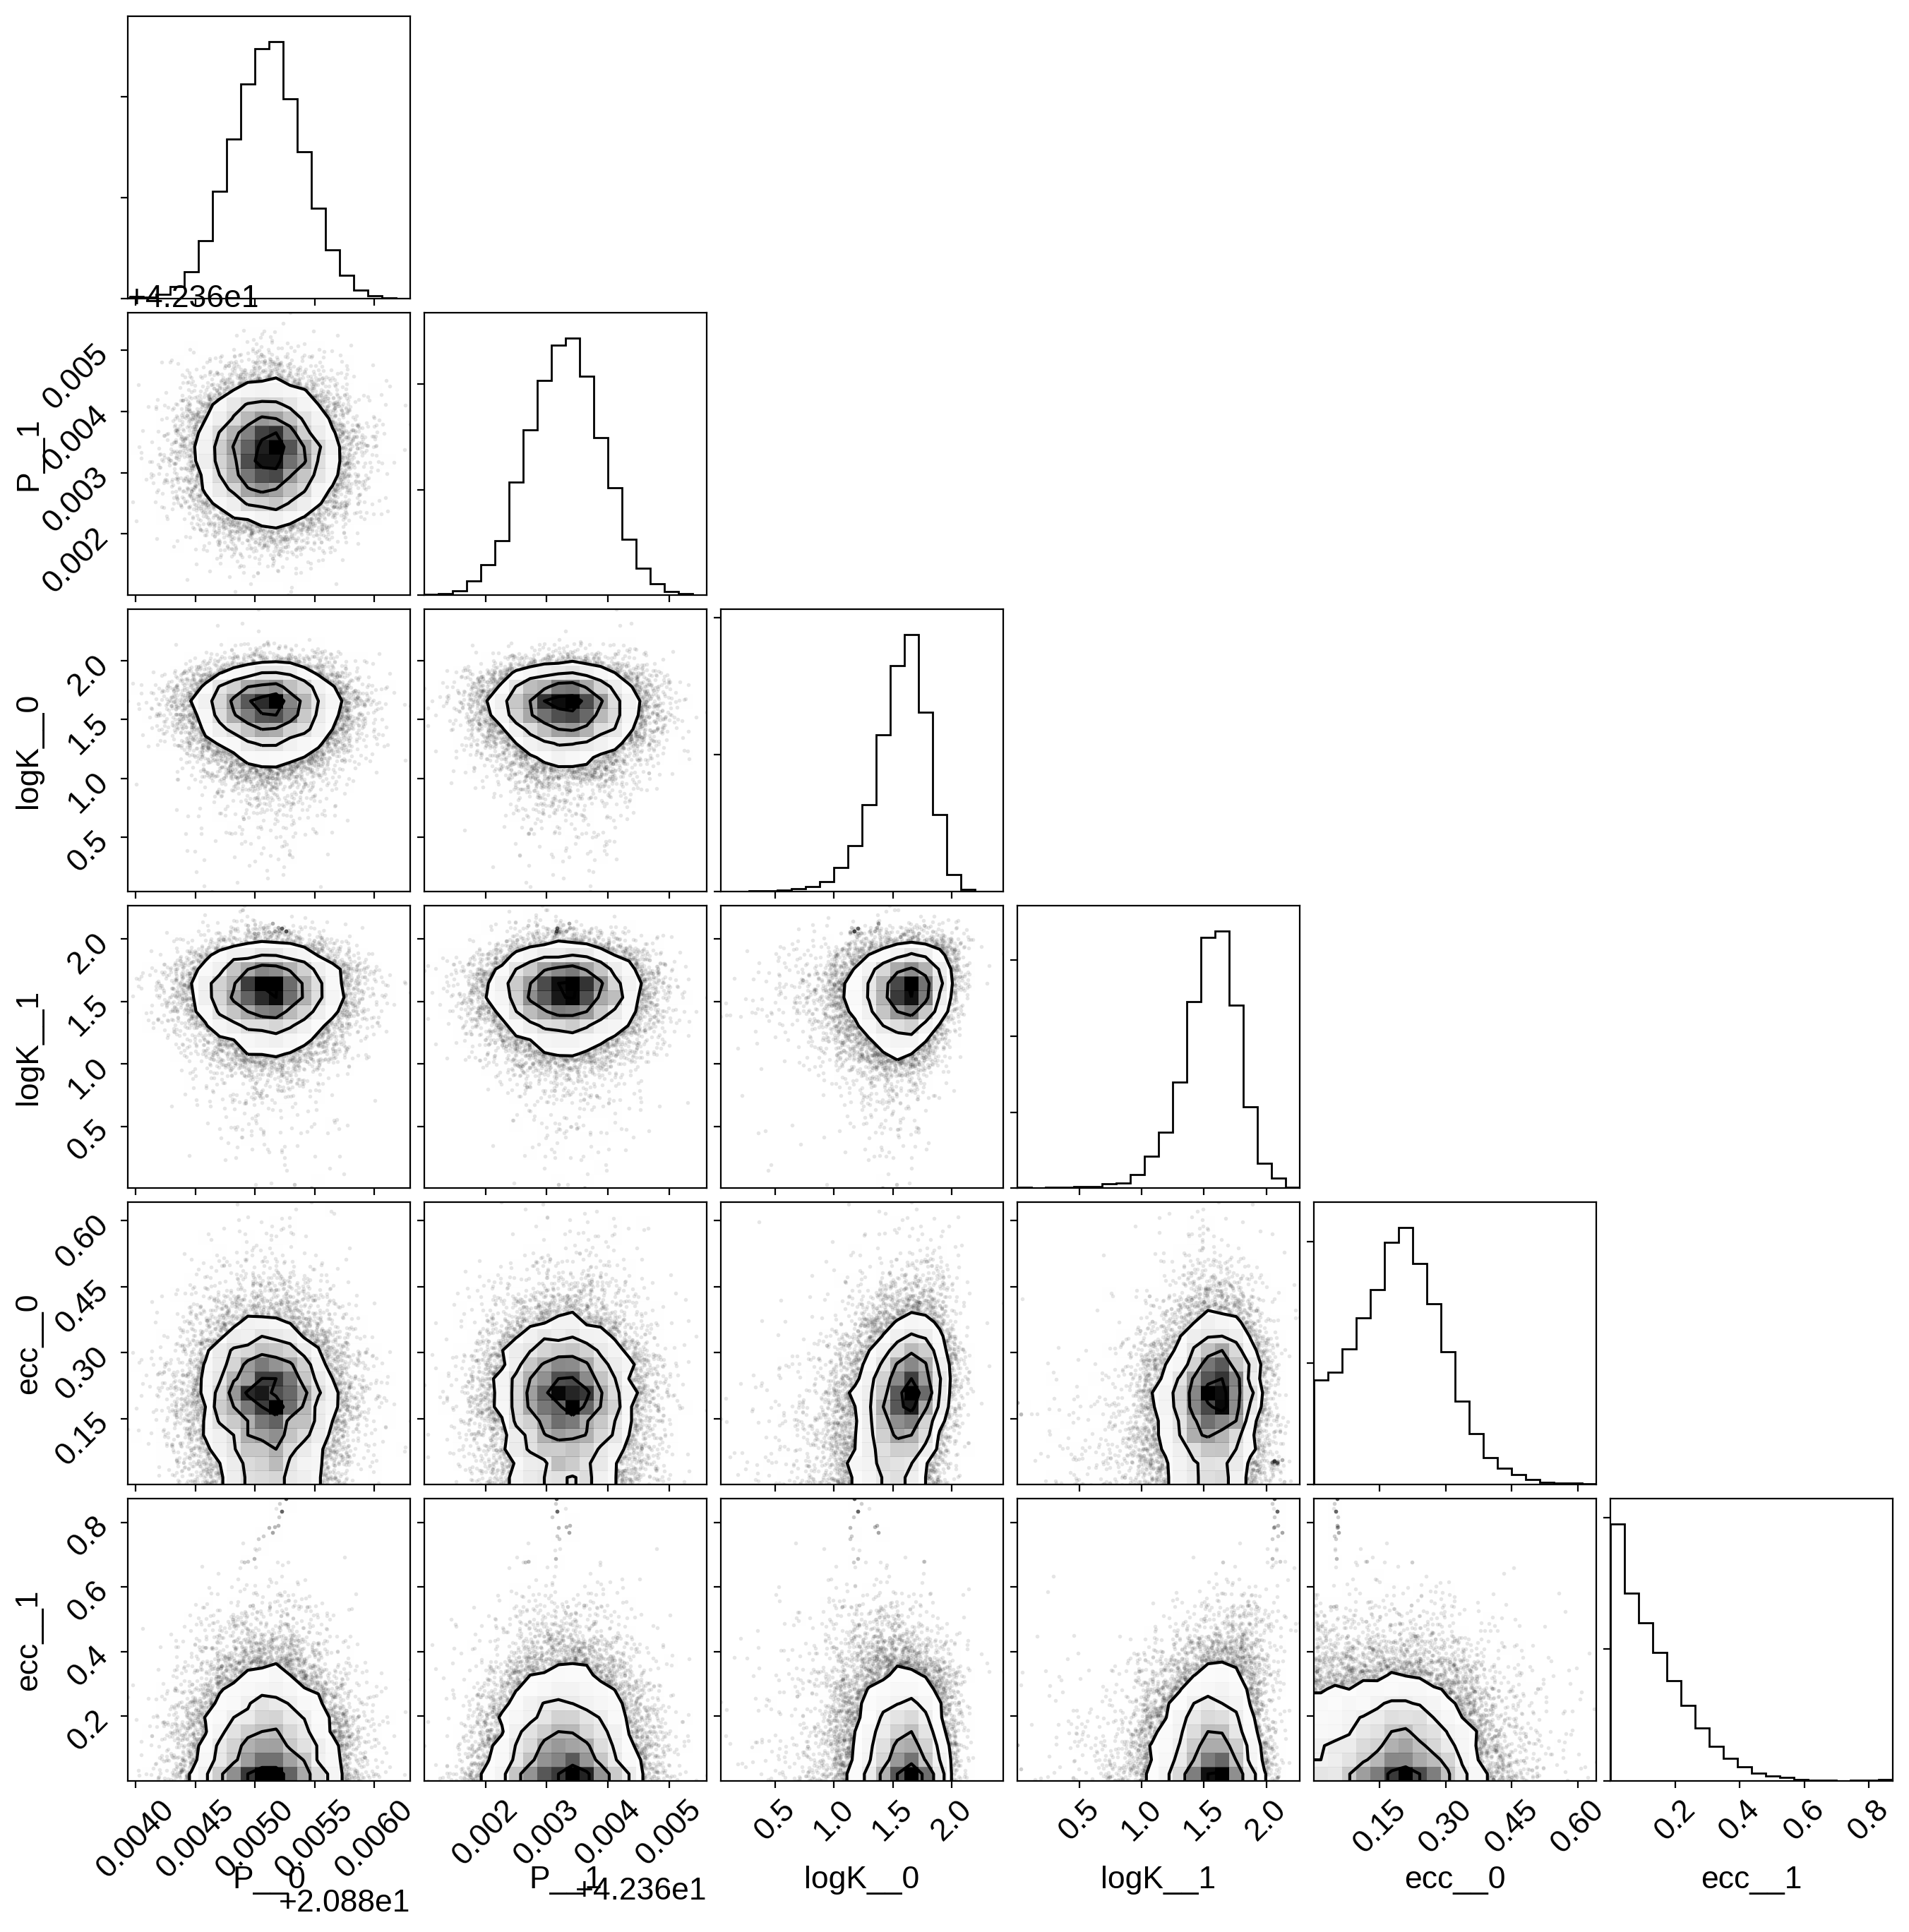

In [13]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc"])
corner.corner(samples);

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

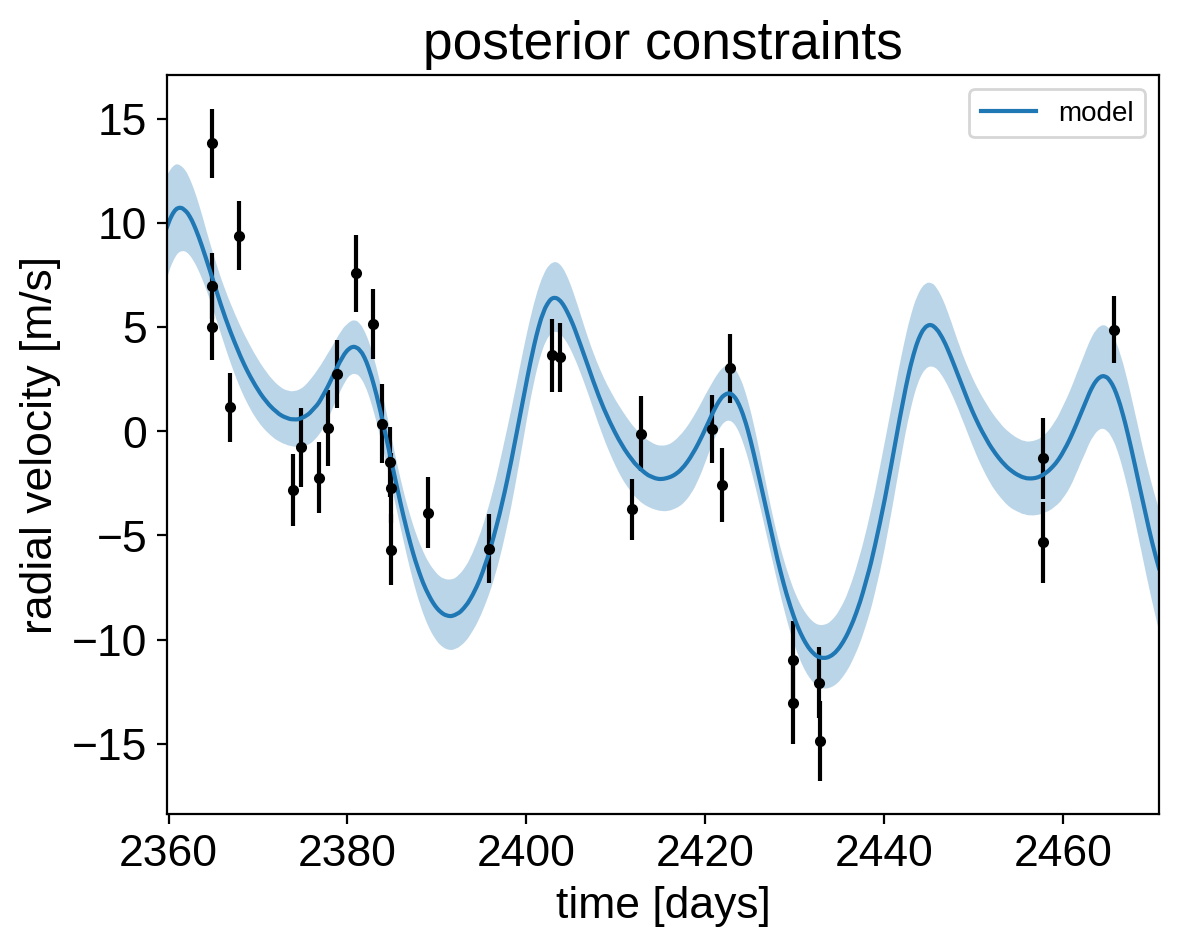

In [14]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("posterior constraints");

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

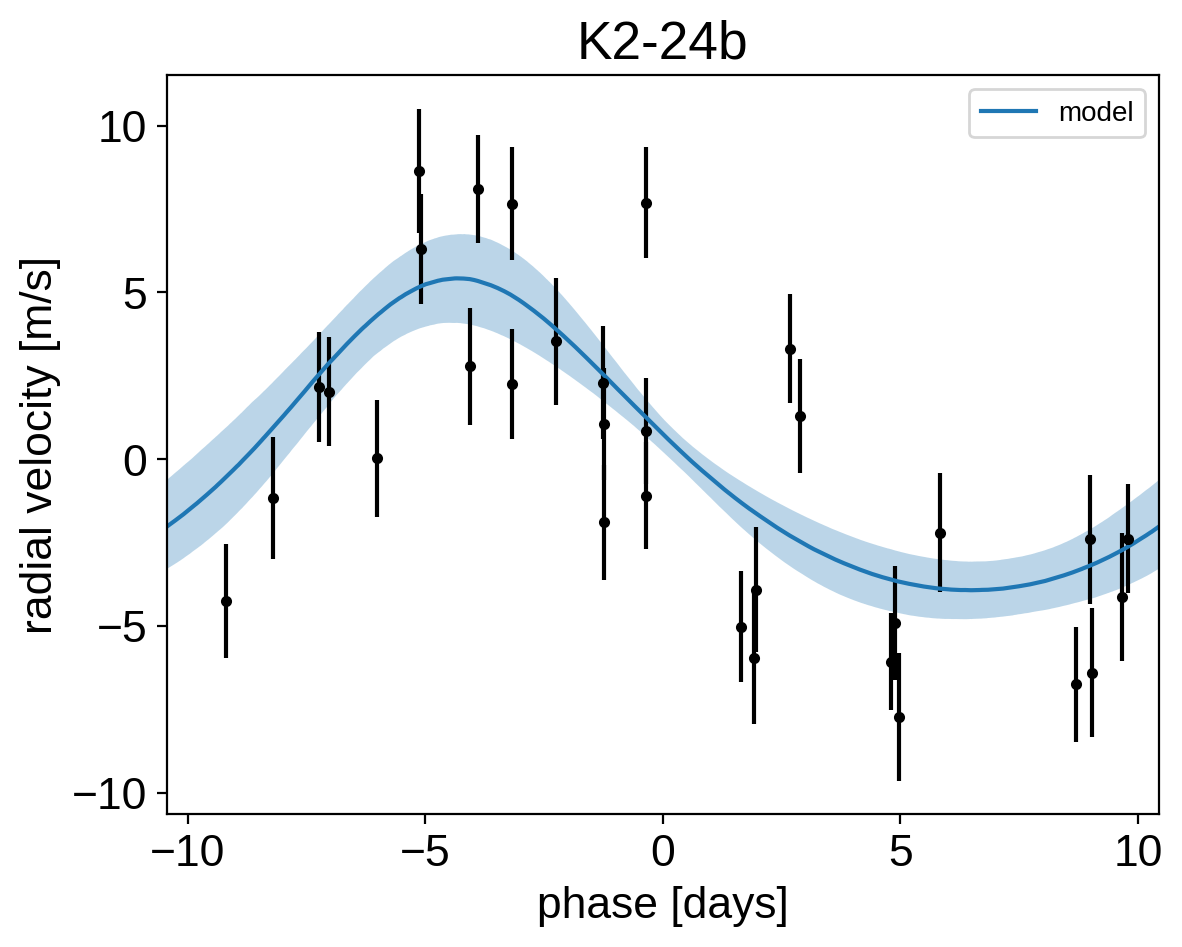

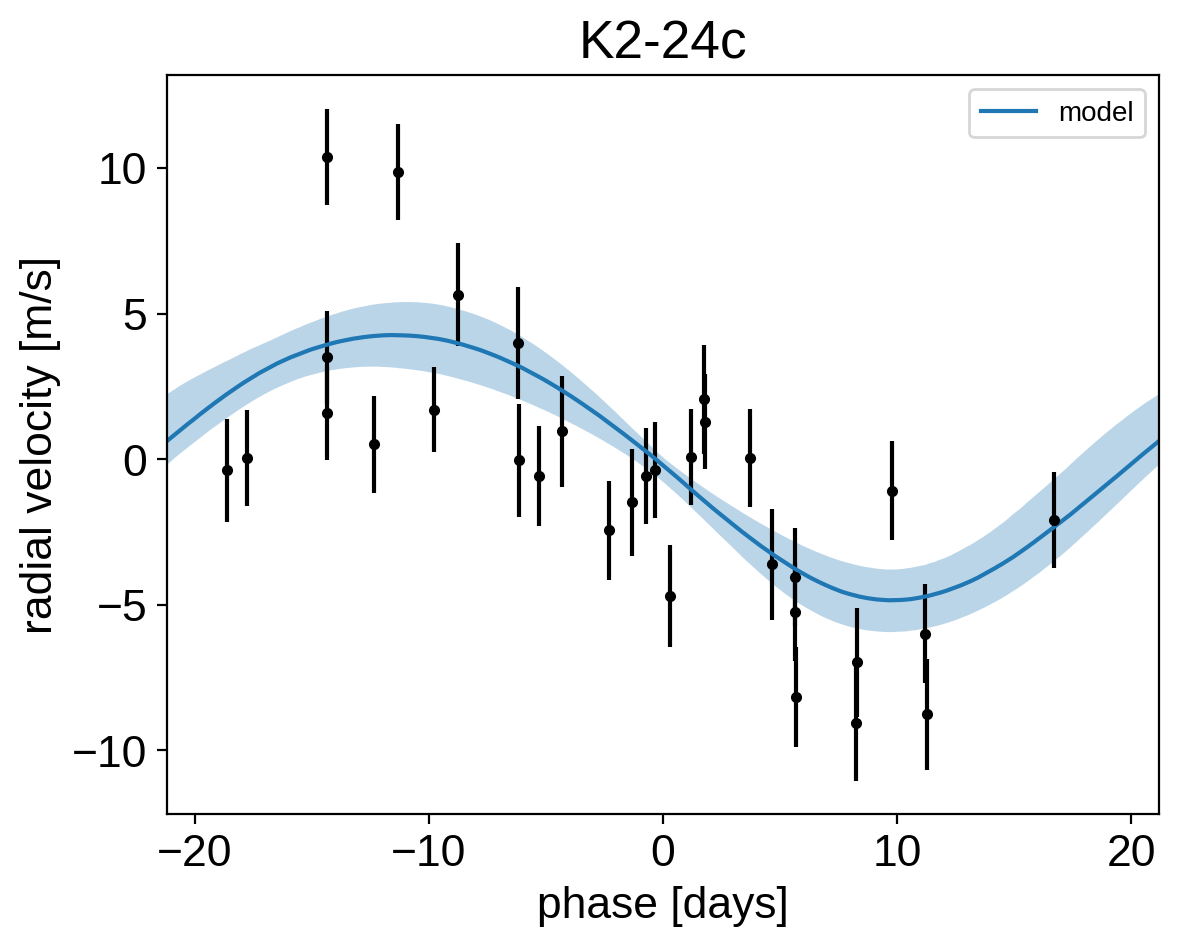

In [15]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [16]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [17]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
